In [1]:
import os,sys
import numpy as np
import matplotlib
import pylab as py
import math
import pandas as pd
from scipy.integrate import quad,fixed_quad

import matplotlib
# %matplotlib inline
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
# #matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# matplotlib.rc('text',usetex=True)
import pylab  as py
# from matplotlib.lines import Line2D

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g8y1eq9a because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


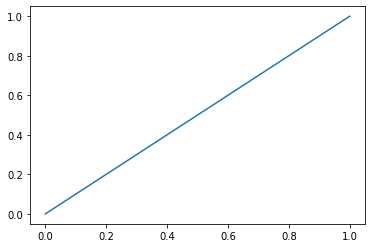

In [2]:
def test():
    ax=py.subplot(111)
    X=np.linspace(0,1,100)
    ax.plot(X,X)
#     ax.semilogx()
    
test()


In [3]:
sys.path.append('/work/JAM/barryp/JAM/fitpack2/')
os.environ['FITPACK']='/work/JAM/barryp/JAM/fitpack2/'

In [4]:
import copy
from tools.config import conf,load_config
from tools.tools import load,save,checkdir,lprint

In [5]:
from qcdlib import aux,mellin

from fitlib.resman import RESMAN
from obslib.pITD import theory
from obslib.ccLCS import theory
from analysis.corelib import core,summary,inspect

In [6]:
from scipy.special import gamma

# Get predictions

In [7]:
def predict(wdir,data='both'):
    load_config('%s/input.py'%wdir)
    istep=core.get_istep()
    replicas=core.get_replicas(wdir)
    rep=replicas[0]
    repnames=sorted(os.listdir('%s/msr-inspected'%wdir))

    core.mod_conf(istep,replicas[0])
    order=replicas[0]['order'][istep]

    conf['bootstrap']=False
#     if data=='pITD' or data=='both':
#         if 'pITD' not in conf['datasets']:
#             conf['datasets']['pITD']={}
#             conf['datasets']['pITD']['filters']=[]
#             conf['datasets']['pITD']['filters'].append('ZoA<9')
#             conf['datasets']['pITD']['filters'].append('ZoA>2')
#             conf['datasets']['pITD']['xlsx']={}
#             conf['datasets']['pITD']['xlsx'][1001]='pITD-pion/expdata/1001.xlsx' #--Real part, large lattice volume
#             conf['datasets']['pITD']['xlsx'][1002]='pITD-pion/expdata/1002.xlsx' #--Real part, small lattice volume
#             conf['datasets']['pITD']['norm']={}

#     if data=='ccLCS' or data=='both':
#         if 'ccLCS' not in conf['datasets']:
#             conf['datasets']['ccLCS']={}
#             conf['datasets']['ccLCS']['filters']=[]
#             conf['datasets']['ccLCS']['xlsx']={}
#             conf['datasets']['ccLCS']['xlsx'][12781]='current-current-pion/expdata/12781.xlsx' #--a=0.094,mpi=278,L=32
#             conf['datasets']['ccLCS']['xlsx'][13581]='current-current-pion/expdata/13581.xlsx' #--a=0.094,mpi=358,L=32
#             conf['datasets']['ccLCS']['xlsx'][14131]='current-current-pion/expdata/14131.xlsx' #--a=0.127,mpi=413,L=32
#             conf['datasets']['ccLCS']['xlsx'][14132]='current-current-pion/expdata/14132.xlsx' #--a=0.127,mpi=413,L=24
#             conf['datasets']['ccLCS']['norm']={}
#     if 'LCS scale' not in conf: conf['LCS scale']=0
    
    resman=RESMAN(nworkers=10,parallel=True,datasets=True)
    parman=resman.parman
    
    obsres={}
    if 'dy-pion' in conf['datasets']: obsres['dy-pion']=resman.dy_pion_res
    if 'ln' in conf['datasets']: obsres['ln']=resman.ln_res
    if data=='pITD' or data=='both':
        obsres['pITD']=resman.pITD_res
    if data=='ccLCS' or data=='both':
        obsres['ccLCS']=resman.ccLCS_res
    
    data={}
    data['order']=order
    data['params']=[]
    data['reactions']={}
    data['res']=[]
    data['rres']=[]
    data['nres']=[]
    
    for _ in obsres:
        tabs=copy.copy(obsres[_].tabs)
        for idx in tabs:
            tabs[idx]['prediction-rep']=[]
            tabs[idx]['residuals-rep']=[]
            tabs[idx]['shift-rep']=[]
        data['reactions'][_]=tabs
        
    for i in range(len(replicas)):
        lprint('progress: %i/%i'%(i+1,len(replicas)))
#         print()
#         print(repnames[i])
        rep=replicas[i]
        parman.par=copy.copy(rep['params'][istep])
        parman.order=copy.copy(rep['order'][istep])
        #--seeing what happens without these parameters
#         for j in range(len(parman.order)):
#             if parman.order[j][2]=='b1-pITD' or parman.order[j][2]=='f1-pITD' or parman.order[j][2]=='p1-pITD':
#                 parman.par[j]=0
#         for j in range(len(parman.order)):
#             if parman.order[j][2]=='b1-ccLCS' or parman.order[j][2]=='p1-ccLCS' or parman.order[j][2]=='r1-ccLCS':
#                 parman.par[j]=0
        data['params']=np.append(data['params'],parman.par)

        res,rres,nres=resman.get_residuals(parman.par,initial=True)
        data['res'].append(res)
        data['rres'].append(rres)
        data['nres'].append(nres)

        for _ in obsres:
            for idx in data['reactions'][_]:
                prediction=copy.copy(obsres[_].tabs[idx]['prediction'])
#                 if _=='ccLCS': print(prediction)
                residuals =copy.copy(obsres[_].tabs[idx]['residuals'])
                #shift     =copy.copy(obsres[_].tabs[idx]['shift'])
                data['reactions'][_][idx]['prediction-rep'].append(prediction)
                data['reactions'][_][idx]['residuals-rep'].append(residuals)
                #data['reactions'][_][idx]['shift-rep'].append(shift)
                
    resman.shutdown()
    for _ in ['res','rres','nres']:
        data[_]=np.array(data[_])
    checkdir('%s/data'%wdir)
    save(data,'%s/data/predictions-%d.dat'%(wdir,istep))

In [8]:
# wdir='/work/JAM/barryp/JAM/analysis-LCS/ccLCS/NLOcconly/step17/'
# wdir='/work/JAM/barryp/JAM/analysis-LCS/ccLCS/NLOmu4/'
# wdir='/work/JAM/barryp/JAM/analysis-LCS/combined/NLOmumc/'
# wdir='/work/JAM/barryp/JAM/analysis-LCS/pITD/NLOFV/'
# wdir='/work/JAM/barryp/JAM/analysis-LCS/pITD/FV/NLOmumcnonu/'

In [9]:
# wdirs=['/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO1p25mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO1p5mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO1p75mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO2p0mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO2p25mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO2p5mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO2p75mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO3p0mc/']



In [10]:
# wdirs=['/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLOmumcnonu/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO1p5mcnonu/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO2p0mcnonu/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO2p5mcnonu/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO3p0mcnonu/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLOmumcnu2/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO1p5mcnu2/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO2p0mcnu2/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO2p5mcnu2/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO3p0mcnu2/']
# wdirs=['/work/JAM/barryp/JAM/analysis-LCS/combinednew/NLOmu2/']
# wdirs=['/work/JAM/barryp/JAM/analysis-LCS/combined/NLO/']

In [11]:
# wdirs=['/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLOmumc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLO1p5mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLOmu2/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLO2p0mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLO2p5mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLO3p0mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLOmu4/']
# wdirs=['/work/JAM/barryp/JAM/analysis-LCS/pITDnew/FV/NLOmumc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/FV/NLOmu1p5mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/FV/NLOmu2p0mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/FV/NLOmu2p5mc/',
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/FV/NLOmu3p0mc/']

# wdirs=['/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/NLOallmu2/',
#        '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/NLOallmu2/']


In [12]:
# wdirs=['/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/NLO_PF_mu2/',
#        '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J0J1/NLO_MFR_mu2/']

In [13]:
wdirspITD=['/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1B1/',
       '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/']#,
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1R1/',
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1M1/',
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1F1/',
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1F1P1/',
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J2F2/',
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J2P2/',
#        '/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J2F2P2/']

In [14]:
wdirsccLCS=['/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J0B0/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J0F0/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J0R0/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J0P0/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J0M0/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J0M0F0/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J0R0M0/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J0R0F0/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J0R0M0F0/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J1F1/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J1M1/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J1R1/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J1M1F1/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J1R1F1/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J1R1M1/',
            '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J1R1M1F1/']

In [15]:
wdir=['/work/JAM/barryp/JAM/analysis-LCS/NLOpy3']

In [16]:
wdirpITD=['/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1allz/']

In [13]:
parentdir='/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/covariance/'

In [14]:
wdirsccLCS=['%s/%s'%(parentdir,os.listdir(parentdir)[_]) for _ in range(len(os.listdir(parentdir)))]

In [13]:
# wdirsccLCS=['/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/R0M0B1F0/',
#             '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/R0M0B1F0F1/',
#             '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/R0M0B1F1/']
# wdirsccLCS=['/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/R1',
#             '/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J2allbigF/']
# wdirsccLCS=['/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/R1M1B1R0P1R2F2P1F1/']
# wdirsccLCS=['/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/onlysys/']
wdirsccLCS=['/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J2B2M2P2R2F2/']
# wdirsccLCS=['/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/covariance/NLO/']

In [56]:
for w in wdirsccLCS:
    inspect.get_msr_inspected(w)
    checkdir('%s/data'%w)
    flag=False
    for k in os.listdir('%s/data'%w):
        if 'predictions' in k: flag=True
    if flag: continue
#     predict(w,data='both')
    if 'pITD' in w: predict(w,data='pITD')
    elif 'ccLCS' in w: predict(w,data='ccLCS')
#     if 'ccLCS' in w: predict(w,data='ccLCS')


get msr inspected (filtered msr files) using /work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/J2B2M2P2R2F2/

progress: 100/100
original  num. samples: 100
inspected num. samples: 100


In [57]:
# predict('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/',data='pITD')

# Data and Theory Comparison

In [58]:
def data_over_theorypITD(predictions,wdir):
    zunique=np.unique(predictions['reactions']['pITD'][1001]['ZoA'])
    nrows=len(predictions['reactions']['pITD'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['pITD']:
        p=predictions['reactions']['pITD'][k]
        #--get chi2
        c=[x for x in p if 'cov' in x]
        cov=np.zeros((len(c),len(c)))
        for i in range(len(c)):
            cov[i]=p[c[i]]
        covinv=np.linalg.inv(cov)
        vect=p['value']-np.mean(p['prediction-rep'],axis=0)
        chi2=np.einsum('i,ij,j',vect,covinv,vect)
        print(chi2)
        npts=len(vect)
        
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
            ax.errorbar(nu,vals/meanthy,yerr=alphas/meanthy,fmt='.',label=r'$z=%i a$'%zunique[i])
            ax.axhline(y=1,color='k',alpha=0.5)
            ax.fill_between(nu,1-stdthy/meanthy,1+stdthy/meanthy,alpha=0.3,fc='y')
            ax.set_ylim(0.99,1.01)
            ax.set_yticks([0.99,0.995,1,1.005,1.01])
            if i==0:
                ax.set_yticklabels([r'$0.99$','',r'$1$','',r'$1.01$'])
            else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
            if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
            ax.legend(fontsize=25,loc='upper left')#,frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
            if i==0: ax.text(0.1,0.3,r'$L=%i$'%p['L'][0],transform=ax.transAxes,size=30)
            if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/data_over_theory_pITD.png'%wdir)

In [17]:
def data_over_theoryccLCS(predictions,wdir):
    zunique=np.unique(predictions['reactions']['ccLCS'][12781]['ZoA'])
    nrows=len(predictions['reactions']['ccLCS'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['ccLCS']:
        p=predictions['reactions']['ccLCS'][k]
        #--get chi2
        thy=np.mean(p['prediction-rep'],axis=0)
        res=(p['value']-thy)/p['alpha']
#             print('k=%s'%k)
#             for i in range(len(res)):
#                 print('z=%f, nu=%f, chi2=%f'%(p['z'][i],p['nu'][i],res[i]**2))
        chi2=np.sum(res**2)
#             print(chi2)
        npts=len(res)
    
        

        
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
            ax.errorbar(nu,vals/meanthy,yerr=alphas/meanthy,fmt='.',label=r'$z=%i a$'%zunique[i])
            ax.axhline(y=1,color='k',alpha=0.5)
            ax.fill_between(nu,1-stdthy/meanthy,1+stdthy/meanthy,alpha=0.3,fc='y')
#             ax.set_ylim(0.8,1.2)
            ax.set_ylim(0.5,1.5)
#             ax.set_yticks([0.8,0.85,0.9,0.95,1,1.05,1.1,1.15,1.2])
            ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5])
            if i==0:
#                 ax.set_yticklabels([r'$0.8$','',r'$0.9$','',r'$1$','',r'$1.1$','',r'$1.2$'])
                ax.set_yticklabels(['',r'$0.6$','',r'$0.8$','',r'$1$','',r'$1.2$','',r'$1.4$',''])
            else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
            if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
            ax.legend(fontsize=25,loc='upper left')#,frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
            if i==0: ax.text(0.1,0.3,r'$L=%i a$'%p['L'][0],transform=ax.transAxes,size=25)
            if i==0: ax.text(0.1,0.18,r'$m_\pi=%i~{\rm MeV}$'%p['mpi'][0],transform=ax.transAxes,size=25)
            if i==0: ax.text(0.1,0.06,r'$a=%.3f~{\rm fm}$'%p['a'][0],transform=ax.transAxes,size=25)
            if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
#     py.savefig('%s/gallery/data_over_theory_ccLCS.png'%wdir)

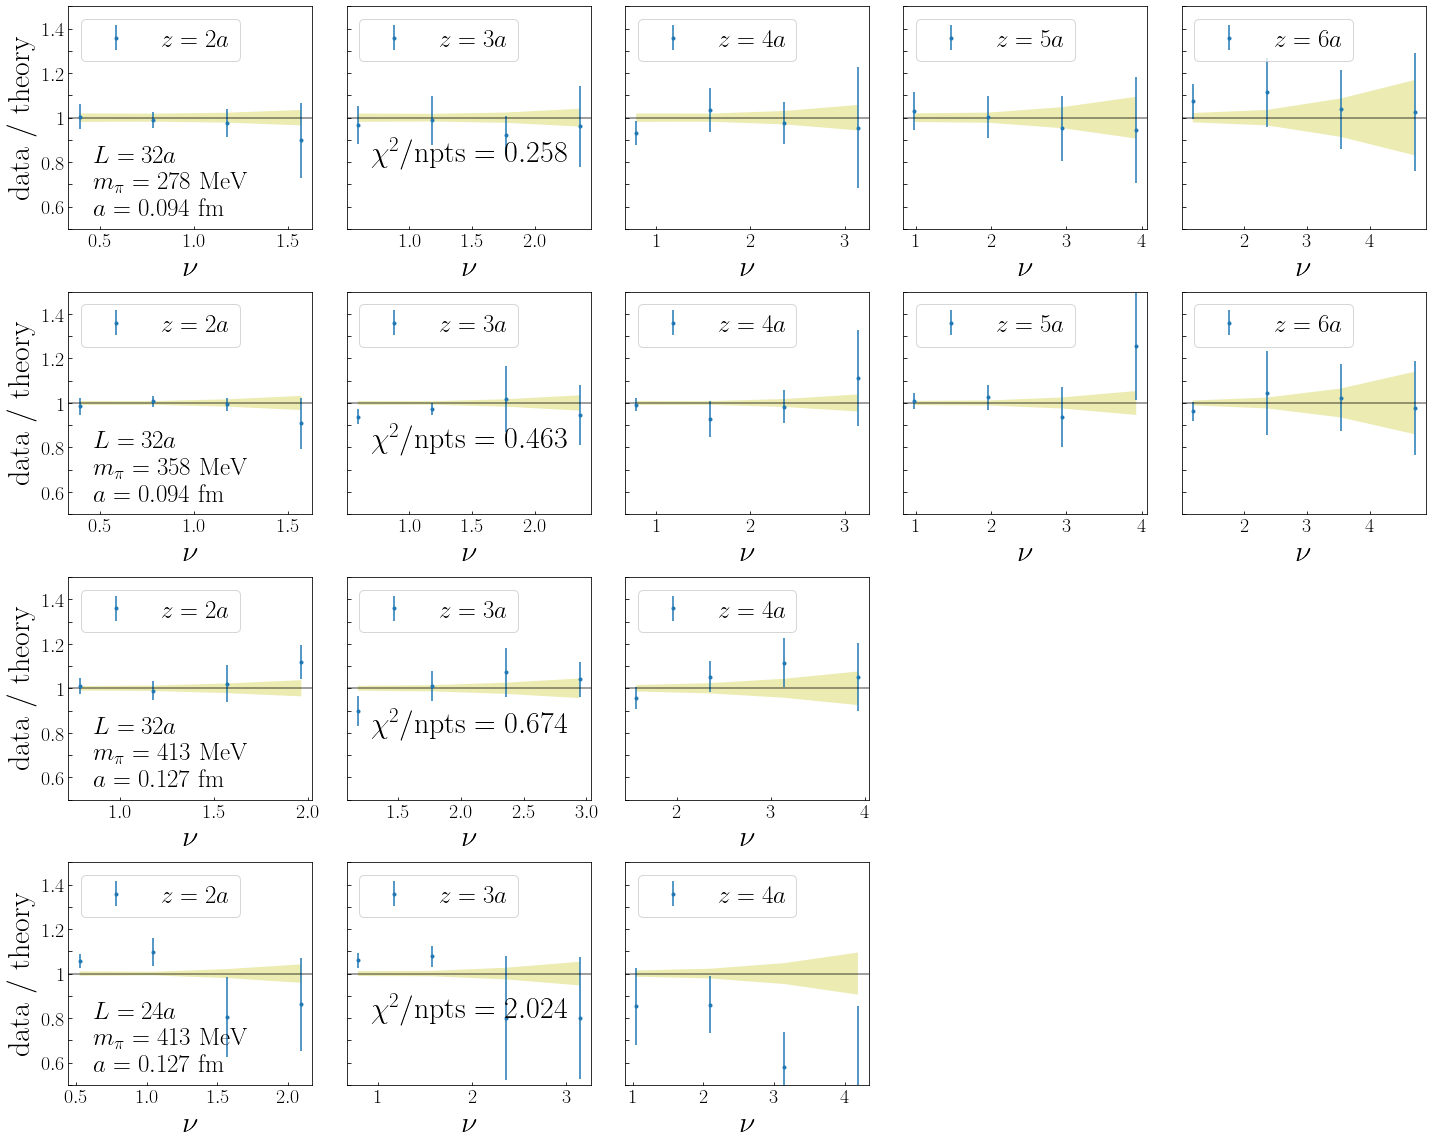

In [18]:
# wdirs2=['/work/JAM/barryp/JAM/analysis-LCS/combinednew/NLOmu2/']
for w in wdirsccLCS:
#     if w!=wdirs[0]: continue
    p=load('%s/data/predictions-17.dat'%w)
#     p=load('%s/data/predictions-18.dat'%w)
#     flag=False
#     for k in os.listdir('%s/gallery'%w):
#         if 'data_over_theory' in k: flag=True
#     if flag: continue
    if 'pITD' in w: data_over_theorypITD(p,w)
    elif 'ccLCS' in w: data_over_theoryccLCS(p,w)
#     data_over_theoryccLCS(p,w)

In [19]:
# w=wdir[0]
# p=load('%s/data/predictions-LCS-16.dat'%w)
# data_over_theorypITD(p,w)
# data_over_theoryccLCS(p,w)

# $\chi^2$

In [20]:
def get_chi2_total(predictions,wdir):
    chi2={}
    for k in predictions['reactions']:
#         if k=='pITD': continue
#         chi2[k]={}
        for kk in predictions['reactions'][k]:
            #--get chi2
#             chi2[k][kk]={}
            chi2[kk]={}
            chi2[kk]['expt']=k
            p=predictions['reactions'][k][kk]
            if k=='pITD':# or k=='ccLCS':
                c=[x for x in p if 'cov' in x]
                cov=np.zeros((len(c),len(c)))
                for i in range(len(c)):
                    cov[i]=p[c[i]]
                covinv=np.linalg.inv(cov)
                vect=p['value']-np.mean(p['prediction-rep'],axis=0)
#                 chi2[k][kk]['chi2 tot']=np.einsum('i,ij,j',vect,covinv,vect)
#                 chi2[k][kk]['npts']=len(p['value'])
#                 chi2[k][kk]['chi2/npts']=np.einsum('i,ij,j',vect,covinv,vect)/len(p['value'])
                chi2[kk]['chi2 tot']=np.einsum('i,ij,j',vect,covinv,vect)
                chi2[kk]['npts']=len(p['value'])
                chi2[kk]['dof']='--'
                chi2[kk]['chi2/npts']=np.einsum('i,ij,j',vect,covinv,vect)/len(p['value'])
                chi2[kk]['chi2/dof']='--'
                
            else:
                res=(p['value']-np.mean(p['prediction-rep'],axis=0))/p['alpha']
#                 chi2[k][kk]['npts']=len(res)
#                 chi2[k][kk]['chi2 tot']=np.sum(res**2)
#                 chi2[k][kk]['chi2/npts']=np.sum(res**2)/len(res)
                chi2[kk]['npts']=len(res)
                chi2[kk]['dof']='--'
                chi2[kk]['chi2 tot']=np.sum(res**2)
                chi2[kk]['chi2/npts']=np.sum(res**2)/len(res)
                chi2[kk]['chi2/dof']='--'
            
    numshapeparams=7
    npts=0
    chi2tot=0
    for k in chi2:
        npts+=chi2[k]['npts']
        chi2tot+=chi2[k]['chi2 tot']
    dof=npts-len(predictions['order'])
    chi2['total']={'expt': '--', 'npts':npts,'dof':dof,'chi2 tot':chi2tot,'chi2/npts': chi2tot/npts,'chi2/dof': chi2tot/dof}
    
    return chi2

In [21]:
chi2fit=get_chi2_total(p,w)

In [22]:
df=pd.DataFrame(chi2fit).T
df

,expt,npts,dof,chi2 tot,chi2/npts,chi2/dof
10001,dy-pion,61,--,50.893116,0.834313,--
10002,dy-pion,36,--,19.38373,0.538437,--
10003,dy-pion,20,--,17.019748,0.850987,--
1000,ln,58,--,20.702017,0.356931,--
2000,ln,50,--,75.164629,1.503293,--
12781,ccLCS,20,--,5.155848,0.257792,--
13581,ccLCS,20,--,9.257556,0.462878,--
14131,ccLCS,12,--,8.089241,0.674103,--
14132,ccLCS,12,--,24.29053,2.024211,--
total,--,289,241,229.956414,0.795697,0.954176


In [29]:
def test(w,istep):
    p=load('%s/data/predictions-%i.dat'%(w,istep))
    chi2fit=get_chi2_total(p,w)
    return pd.DataFrame(chi2fit).T

In [30]:
tab=test('/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/R0M0B1F0/',17)
print(r'R_1')
tab

R_1


,expt,npts,dof,chi2 tot,chi2/npts,chi2/dof
10001,dy-pion,61,--,50.72175,0.831504,--
10002,dy-pion,36,--,20.595575,0.572099,--
10003,dy-pion,20,--,18.611542,0.930577,--
1000,ln,58,--,20.958835,0.361359,--
2000,ln,50,--,73.021799,1.460436,--
12781,ccLCS,20,--,5.708872,0.285444,--
13581,ccLCS,20,--,11.456986,0.572849,--
14131,ccLCS,12,--,15.52939,1.294116,--
14132,ccLCS,12,--,21.816762,1.818064,--
total,--,289,252,238.42151,0.824988,0.946117


In [92]:
tab=test('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1B1/',17)
print(r'B_1')
tab

B_1


,npts,dof,chi2 tot,chi2/npts,chi2/dof
1001,18.0,16.2,18.795414,1.044190,1.160211
1002,12.0,10.8,25.831327,2.152611,2.391790


In [28]:
# tabpITD=test('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/NLOallmu2/',17)
# tabccLCS=test('/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/NLOallmu2/',17)

In [66]:
# tab0mu1p25mc=t/work/('/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO1p25mc/',17)
# tab0mu1p5mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO1p5mc/',17)
# tab0mu1p75mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO1p75mc/',17)
# tab0mu2p0mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO2p0mc/',17)
# tab0mu2p25mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO2p25mc/',17)
# tab0mu2p5mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO2p5mc/',17)
# tab0mu2p75mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO2p75mc/',17)
# tab0mu3p0mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/muvary/NLO3p0mc/',17)
# tab0mumc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/NLOmumc/',17)
# tab0mu2=test('/work/JAM/barryp/JAM/analysis-LCS/combined/NLO/',17)
# tab0mu4=test('/work/JAM/barryp/JAM/analysis-LCS/combined/NLOmu4/',17)
# tabs0={1.27: tab0mumc, 1.25*1.27: tab0mu1p25mc, 1.5*1.27: tab0mu1p5mc, 2.0: tab0mu2, 1.75*1.27: tab0mu1p75mc,
#       2.0*1.27: tab0mu2p0mc, 2.25*1.27: tab0mu2p25mc, 2.5*1.27: tab0mu2p5mc, 2.75*1.27: tab0mu2p75mc, 3.0*1.27: tab0mu3p0mc, 4.0: tab0mu4}


In [67]:
# tab1mumc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLOmumcnonu')
# tab1mu1p5mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO1p5mcnonu')
# tab1mu2p0mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO2p0mcnonu')
# tab1mu2p5mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO2p5mcnonu')
# tab1mu3p0mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO3p0mcnonu')
# tabs1={1.27: tab1mumc, 1.5*1.27: tab1mu1p5mc, 2.0*1.27: tab1mu2p0mc, 2.5*1.27: tab1mu2p5mc, 3.0*1.27: tab1mu3p0mc}


In [68]:
# tab1mumc=test('/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLOmumc',18)
# tab1mu1p5mc=test('/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLO1p5mc',18)
# tab1mu2=test('/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLOmu2',18)
# tab1mu2p0mc=test('/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLO2p0mc',18)
# tab1mu2p5mc=test('/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLO2p5mc',18)
# tab1mu3p0mc=test('/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLO3p0mc',18)
# tab1mu4=test('/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLOmu4',18)
# tabs1={1.27: tab1mumc, 1.5*1.27: tab1mu1p5mc, 2.0: tab1mu2, 2.0*1.27: tab1mu2p0mc, 2.5*1.27: tab1mu2p5mc, 3.0*1.27: tab1mu3p0mc, 4.0: tab1mu4}


# tab1mumc=test('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/FV/NLOmumc',17)
# tab1mu1p5mc=test('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/FV/NLOmu1p5mc',17)
# tab1mu2p0mc=test('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/FV/NLOmu2p0mc',17)
# tab1mu2p5mc=test('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/FV/NLOmu2p5mc',17)
# tab1mu3p0mc=test('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/FV/NLOmu3p0mc',17)
# tabs1={1.27: tab1mumc, 1.5*1.27: tab1mu1p5mc, 2.0*1.27: tab1mu2p0mc, 2.5*1.27: tab1mu2p5mc, 3.0*1.27: tab1mu3p0mc}


In [69]:
# tab2mumc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLOmumcnu2')
# tab2mu1p5mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO1p5mcnu2')
# tab2mu2p0mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO2p0mcnu2')
# tab2mu2p5mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO2p5mcnu2')
# tab2mu3p0mc=test('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLO3p0mcnu2')
# tabs2={1.27: tab2mumc, 1.5*1.27: tab2mu1p5mc, 2.0*1.27: tab2mu2p0mc, 2.5*1.27: tab2mu2p5mc, 3.0*1.27: tab2mu3p0mc}


In [70]:
def test():
    nrows,ncols=3,4
    py.figure(figsize=(6*ncols,4*nrows))
    cnt=0
#     tables=[tabs0,tabs1,tabs2]
    tables=[tabs0,tabs1]
    colors=['r','b','g']
    for k in tables[1][1.27].T:
        cnt+=1
        for i in range(len(tables)):
            ax=py.subplot(nrows,ncols,cnt)
            chi2=[]
            for kk in tables[i]:
                chi2.append(tables[i][kk].T[k]['chi2/npts'])
            mus=np.array(list(tables[i]))
            ax.plot(mus,chi2,'o',color=colors[i])
            if i==0: ax.plot(mus,chi2,'-',color=colors[i],label=r'$\rm no~systematics$')
            elif i==1: ax.plot(mus,chi2,'-',color=colors[i],label=r'${\rm systematics}$')
            elif i==2: ax.plot(mus,chi2,'-',color=colors[i],label=r'${\rm FV}_2$')
    #         ax.set_ylim(0,1.5)
            if cnt>=9: ax.set_xlabel(r'$\mu_{\rm latt}~({\rm GeV})$',size=40)
            if k!='total': 
                if k==1001 or k==14131:
                    ax.text(0.3,0.8,r'$\rm a127m413L~%s$'%(tables[i][1.27].T[k]['expt']),transform=ax.transAxes,size=25)
                elif k==1002 or k==14132:
                    ax.text(0.3,0.8,r'$\rm a127m413~%s$'%(tables[i][1.27].T[k]['expt']),transform=ax.transAxes,size=25)
                elif k==12781:
                    ax.text(0.3,0.8,r'$\rm a94m278~%s$'%(tables[i][1.27].T[k]['expt']),transform=ax.transAxes,size=25)
                elif k==13581:
                    ax.text(0.3,0.8,r'$\rm a94m358~%s$'%(tables[i][1.27].T[k]['expt']),transform=ax.transAxes,size=25)
                else:
                    ax.text(0.3,0.8,r'$\rm %s~%s$'%(k,tables[i][1.27].T[k]['expt']),transform=ax.transAxes,size=25)
            if k=='total': ax.text(0.3,0.8,r'$\bf total$',transform=ax.transAxes,size=30)
            ax.tick_params(direction='in',which='both',labelsize=20)
            ax.set_xticks([1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0])
            ax.set_xticklabels([r'$1$',r'',r'',r'',r'',r'$2$','','','','',r'$3$','','','','',r'$4$'])
            if cnt%4==1: ax.set_ylabel(r'$\chi^2_{\rm dat}$',size=40)
            if cnt==8: ax.legend(frameon=False,fontsize=30,loc='center right')
    py.tight_layout()
    checkdir('new_gallery')
#     py.savefig('new_gallery/chi2vsmu_systematics.png')
#     py.savefig('new_gallery/chi2vsmu_systematics.pdf')

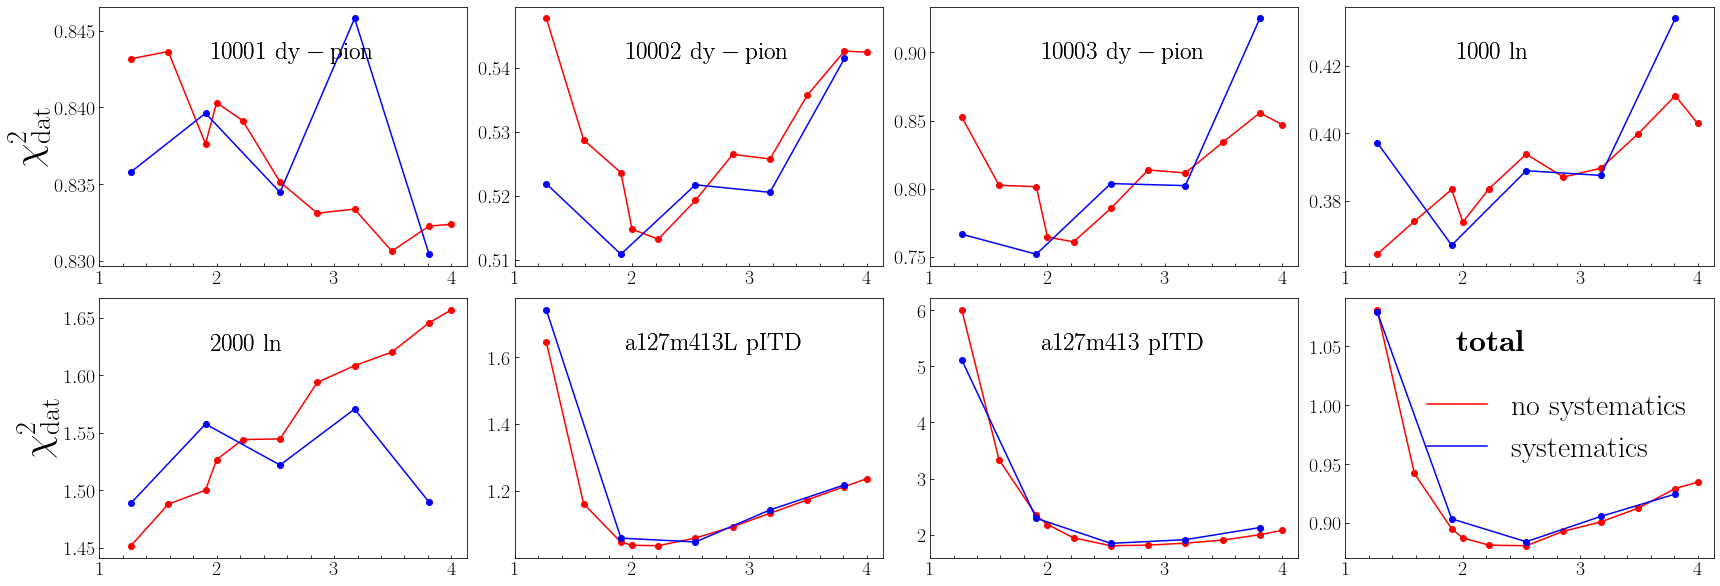

In [71]:
test()

# Generate PDFs/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/

In [31]:
def gen_pdf(wdir,Q2=None):
    load_config('%s/input.py'%wdir)
    istep=core.get_istep()
    replicas=core.get_replicas(wdir)
#     rep=replicas[0]
#     repname=os.listdir('%s/msr-inspected/'%wdir)[0]

    core.mod_conf(istep,replicas[0])
    order=replicas[0]['order'][istep]

    conf['bootstrap']=False
    
    resman=RESMAN(nworkers=10,parallel=True,datasets=True)
    parman=resman.parman
    
    pdf=conf['pdf-pion']

    if Q2==None: Q2=conf['Q20']
    X=10**np.linspace(-3,-1,200)
    X=np.append(X,np.linspace(0.1,1,200))
    XF={}

    for i in range(len(replicas)):
        rep=replicas[i]
        lprint('progress: %i/%i'%(i+1,len(replicas)))

        parman.order=rep['order'][istep]
        parman.set_new_params(rep['params'][istep])

        for flav in ['valence','sea','g']:
            if flav not in XF: XF[flav]=[]

            if flav=='valence':
                func=lambda x: pdf.get_xF(x,Q2,'ub')-pdf.get_xF(x,Q2,'u')
            elif flav=='sea':
                func=lambda x: pdf.get_xF(x,Q2,'u')
            else:
                func=lambda x: pdf.get_xF(x,Q2,'g')

            XF[flav].append([func(x) for x in X])

    resman.shutdown()
    
    checkdir('%s/data'%wdir)
    save({'X':X,'Q2':Q2,'XF':XF},'%s/data/pdf-%d.dat'%(wdir,istep))

In [32]:
# gen_pdf('/work/JAM/barryp/Notebooks-Jupyterhub/doublemellincopy/step18pos/')
# gen_pdf(wdirpITD[0])
# gen_pdf('/work/JAM/barryp/JAM/analysis-LCS/pITD/pITDnlo_allp/')
# gen_pdf('/work/JAM/barryp/JAM/analysis-LCS/NLLpy3_cosine')
# gen_pdf('/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/covariance/NLO/')
for w in wdirsccLCS:
    gen_pdf(w)

loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading ccLCS data sets 22781
loading ccLCS data sets 23581
loading ccLCS data sets 24131
loading ccLCS data sets 24132
progress: 100/100loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading ccLCS data sets 22781
loading ccLCS data sets 23581
loading ccLCS data sets 24131
loading ccLCS data sets 24132
progress: 100/100

In [33]:
# for w in wdirspITD:
#     gen_pdf(w)
# gen_pdf('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/')

In [34]:
PDFs={}

In [23]:
# mu2=load('/work/JAM/barryp/JAM/analysis-LCS/pITD/pITDnlo_allp/data/pdf-17.dat')
# mumc=load('/work/JAM/barryp/JAM/analysis-LCS/pITD/NLOmumc/data/pdf-17.dat')
# mu4=load('/work/JAM/barryp/JAM/analysis-LCS/pITD/NLOmu4/data/pdf-17.dat')

# mu2=load('/work/JAM/barryp/JAM/analysis-LCS/ccLCS/NLOcconly/data/pdf-17.dat')
# mumc=load('/work/JAM/barryp/JAM/analysis-LCS/ccLCS/NLOmumc/data/pdf-17.dat')
# mu4=load('/work/JAM/barryp/JAM/analysis-LCS/ccLCS/NLOmu4/data/pdf-17.dat')

# mu2=load('/work/JAM/barryp/JAM/analysis-LCS/combined/NLO/data/pdf-17.dat')
# mumc=load('/work/JAM/barryp/JAM/analysis-LCS/combined/NLOmumc/data/pdf-17.dat')
# mu4=load('/work/JAM/barryp/JAM/analysis-LCS/combined/NLOmu4/data/pdf-17.dat')

# noFV=load('/work/JAM/barryp/JAM/analysis-LCS/combined/NLOmumc/data/pdf-17.dat')
# FV1=load('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLOmumcnonu/data/pdf-18.dat')
# FV2=load('/work/JAM/barryp/JAM/analysis-LCS/combined/FV/NLOmumcnu2/data/pdf-18.dat')

# noFV=load('/work/JAM/barryp/JAM/analysis-LCS/combinednew/NLOmu2/data/pdf-17.dat')
# FV1=load('/work/JAM/barryp/JAM/analysis-LCS/combinednew/systematics/NLOmu2/data/pdf-18.dat')

# old=load('/work/JAM/barryp/JAM/analysis-LCS/pITD/pITDnlo_allp/data/pdf-17.dat')
# new=load('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/data/pdf-17.dat')

In [24]:
# PDFs[r'$\mu=2~{\rm GeV}$']=mu2
# PDFs[r'$\mu=m_c$']=mumc
# PDFs[r'$\mu=4~{\rm GeV}$']=mu4

PDFs={}
PDFs[r'${\rm no~systematics}$']=old
PDFs[r'${\rm systematics}_1$']=new
# PDFs[r'${\rm FV}_2$']=FV2

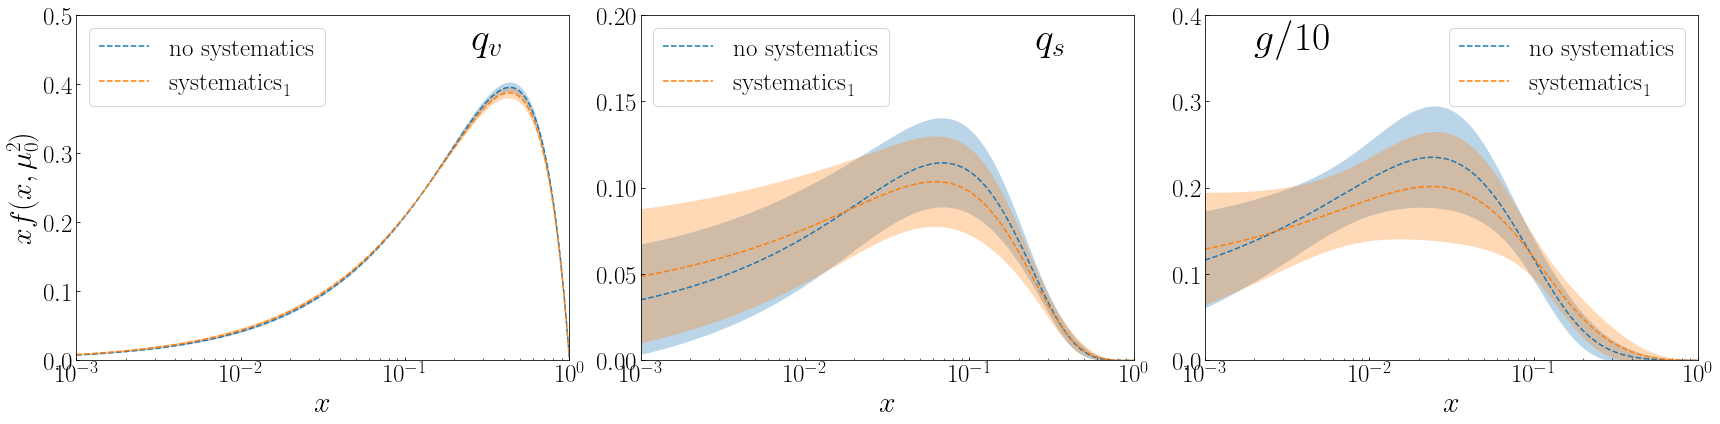

In [25]:
nrows,ncols=1,3
# nrows,ncols=3,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
for k in PDFs:
    meanpdf=np.mean(PDFs[k]['XF']['valence'],axis=0)
    stdpdf=np.std(PDFs[k]['XF']['valence'],axis=0)
    X=PDFs[k]['X']
    ax.plot(X,meanpdf,'--',label=k)
    ax.fill_between(X,meanpdf-stdpdf,meanpdf+stdpdf,alpha=0.3)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xf(x,\mu_0^2)$',size=30)
ax.legend(fontsize=25)
ax.text(0.8,0.9,r'$q_v$',transform=ax.transAxes,size=40)
ax.set_ylim(0,0.5)
ax.set_xlim(1e-3,1)
ax.tick_params(direction='in',which='both',labelsize=25)
ax.semilogx()


ax=py.subplot(nrows,ncols,2)
for k in PDFs:
    meanpdf=np.mean(PDFs[k]['XF']['sea'],axis=0)
    stdpdf=np.std(PDFs[k]['XF']['sea'],axis=0)
    X=PDFs[k]['X']
    ax.plot(X,meanpdf,'--',label=k)
    ax.fill_between(X,meanpdf-stdpdf,meanpdf+stdpdf,alpha=0.3)
ax.set_xlabel(r'$x$',size=30)
# ax.set_ylabel(r'$xq_s(x,\mu_0^2)$',size=30)
ax.legend(fontsize=25,loc='upper left')
ax.text(0.8,0.9,r'$q_s$',transform=ax.transAxes,size=40)
ax.set_ylim(0,0.2)
ax.set_xlim(1e-3,1)
ax.tick_params(direction='in',which='both',labelsize=25)
ax.semilogx()

ax=py.subplot(nrows,ncols,3)
for k in PDFs:
    meanpdf=np.mean(PDFs[k]['XF']['g'],axis=0)/10
    stdpdf=np.std(PDFs[k]['XF']['g'],axis=0)/10
    X=PDFs[k]['X']
    ax.plot(X,meanpdf,'--',label=k)
    ax.fill_between(X,meanpdf-stdpdf,meanpdf+stdpdf,alpha=0.3)
ax.set_xlabel(r'$x$',size=30)
# ax.set_ylabel(r'$xg/10(x,\mu_0^2)$',size=30)
ax.legend(fontsize=25)
ax.text(0.1,0.9,r'$g/10$',transform=ax.transAxes,size=40)
ax.set_ylim(0,0.4)
ax.set_xlim(1e-3,1)
ax.tick_params(direction='in',which='both',labelsize=25)
ax.semilogx()

py.tight_layout()

# checkdir('lattice_gallery')
checkdir('new_gallery')
# py.savefig('lattice_gallery/PDFs_pITD_varymu.png')
# py.savefig('lattice_gallery/PDFs_ccLCS_varymu.png')
# py.savefig('lattice_gallery/PDFs_combined_varymu.png')
# py.savefig('new_gallery/PDFs_systematics_mu2.png')

In [26]:
# wdirs

In [27]:
# oldpdf=load('/work/JAM/barryp/JAM/analysis-LCS/NLOpy3/data/pdf-16.dat')
# oldpdf=load('/work/JAM/barryp/JAM/analysis-LCS/NLLpy3_cosine/data/pdf-18.dat')
# oldpdf=load('/work/JAM/barryp/JAM/analysis-LCS/pITD/pITDnlo_allp/data/pdf-17.dat')
# oldpdf=load('/work/JAM/barryp/JAM/analysis-LCS/combinednew/NLOmu2/data/pdf-17.dat')
# newpdf=load('%s/data/pdf-17.dat'%wdirs[0])
# oldpdf=old
# newpdf=new#load('%s/data/pdf-18.dat'%wdirs[2])
# newpdf=load('%s/data/pdf-19.dat'%wdir)
# newpdf=load('/work/JAM/barryp/Notebooks-Jupyterhub/cosinecopy/step18pos/data/pdf-18.dat')

In [50]:
oldpdf=load('/work/JAM/barryp/JAM/analysis-LCS/NLOpy3/data/pdf-16.dat')
newpdf=load('/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/covariance/NLOsys/data/pdf-17.dat')
# newpdf=load('/work/JAM/barryp/JAM/analysis-LCS/ccLCS/NLOcconly/data/pdf-17.dat')

In [51]:
print(newpdf['X'][-1])
print(newpdf['XF']['valence'][0][-1])

1.0
0.004956453179461561


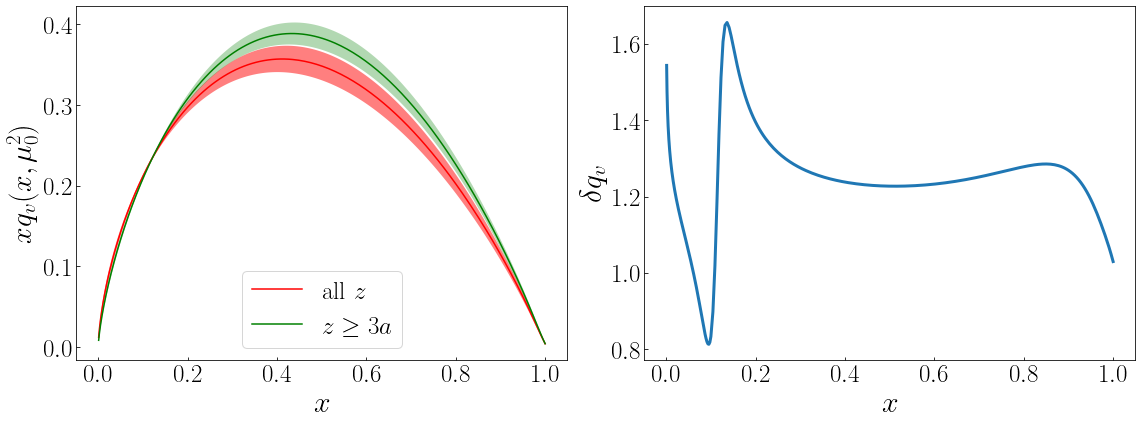

In [53]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0),'r',label=r'${\rm all}~z$')
ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0)-np.std(newpdf['XF']['valence'],axis=0),np.mean(newpdf['XF']['valence'],axis=0)+np.std(newpdf['XF']['valence'],axis=0),alpha=0.5,fc='r')
# ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0),'r',label=r'$\rm no systematics$')
ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0),'g',label=r'$z\geq 3a$')
ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0)-np.std(oldpdf['XF']['valence'],axis=0),np.mean(oldpdf['XF']['valence'],axis=0)+np.std(oldpdf['XF']['valence'],axis=0),alpha=0.3,fc='g')
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xq_v(x,\mu_0^2)$',size=30)
ax.legend(fontsize=25)
ax.tick_params(direction='in',which='both',labelsize=25)


# ax=py.subplot(nrows,ncols,1)
# for i in range(len(newpdf['XF']['valence'])):
#     ax.plot(newpdf['X'],newpdf['XF']['valence'][i],'r',label=r'${\rm all}~z$',zorder=i,alpha=0.1)
# # ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0)-np.std(newpdf['XF']['valence'],axis=0),np.mean(newpdf['XF']['valence'],axis=0)+np.std(newpdf['XF']['valence'],axis=0),alpha=0.5,fc='r')
# # ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0),'r',label=r'$\rm no systematics$')
# for i in range(len(oldpdf['XF']['valence'])):
#     ax.plot(oldpdf['X'],oldpdf['XF']['valence'][i],'g',label=r'$z\geq 3a$',zorder=i,alpha=0.1)
# # ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0)-np.std(oldpdf['XF']['valence'],axis=0),np.mean(oldpdf['XF']['valence'],axis=0)+np.std(oldpdf['XF']['valence'],axis=0),alpha=0.3,fc='g')
# # ax.set_xlabel(r'$x$',size=30)
# # ax.set_ylabel(r'$xq_v(x,\mu_0^2)$',size=30)
# # ax.legend(fontsize=25)
# # ax.tick_params(direction='in',which='both',labelsize=25)

ax=py.subplot(nrows,ncols,2)
ax.plot(newpdf['X'],np.std(newpdf['XF']['valence'],axis=0)/np.std(oldpdf['XF']['valence'],axis=0),lw=3)
# ax.plot(newpdf['X'],np.std(newpdf['XF']['valence'],axis=0)/newpdf['X']/np.mean(newpdf['XF']['valence'],axis=0),'r',lw=3)
# ax.plot(oldpdf['X'],np.std(oldpdf['XF']['valence'],axis=0)/oldpdf['X']/np.mean(oldpdf['XF']['valence'],axis=0),'g',lw=3)
ax.set_xlabel(r'$x$',size=30)
# ax.semilogy()
# ax.set_ylim(0,0.2)
ax.set_ylabel(r'$\delta q_v$',size=30)
ax.tick_params(direction='in',which='both',labelsize=25)

py.tight_layout()
# py.savefig('new_gallery/pdfval_comp_pITD_all_z.png')

In [71]:
oldpdf=load('/work/JAM/barryp/JAM/analysis-LCS/NLOpy3/data/pdf-16.dat')
# midpdf=load('/work/JAM/barryp/JAM/analysis-LCS/pITD/pITDnlo_allp/data/pdf-17.dat')
newpdf=load('/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/covariance/NLO/data/pdf-17.dat')
# newpdf=load('/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/data/pdf-17.dat')
# oldpdf=load('/work/JAM/barryp/JAM/analysis-LCS/NLLpy3_cosine/data/pdf-18.dat')
# oldpdf=load('/work/JAM/barryp/JAM/analysis-LCS/pITD/pITDnlo_allp/data/pdf-17.dat')
# oldpdf=load('/work/JAM/barryp/JAM/analysis-LCS/combinednew/NLOmu2/data/pdf-17.dat')
# newpdf=load('%s/data/pdf-17.dat'%wdirs[0])
# oldpdf=old
# newpdf=load('%s/data/pdf-18.dat'%wdirs[2])
# newpdf=load('%s/data/pdf-19.dat'%wdir)
# newpdf=load('/work/JAM/barryp/Notebooks-Jupyterhub/cosinecopy/step18pos/data/pdf-18.dat')

In [72]:
print(newpdf['X'][-1])
print(newpdf['XF']['valence'][0][-1])

1.0
0.005676217222703424


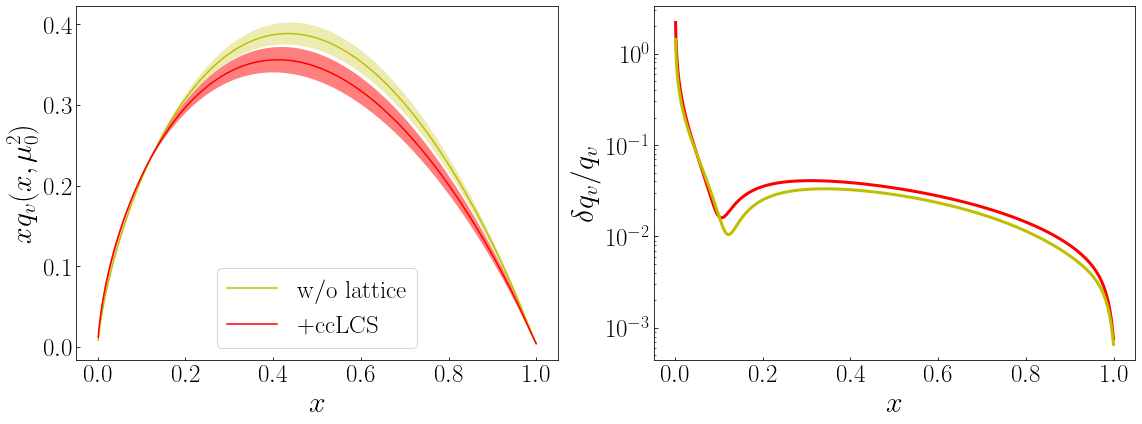

In [76]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
# ax.plot(midpdf['X'],np.mean(midpdf['XF']['valence'],axis=0),'g',label=r'$\rm no~systematics$')
# ax.fill_between(midpdf['X'],np.mean(midpdf['XF']['valence'],axis=0)-np.std(midpdf['XF']['valence'],axis=0),np.mean(midpdf['XF']['valence'],axis=0)+np.std(midpdf['XF']['valence'],axis=0),alpha=0.5,fc='g')
ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0),'y',label=r'$\rm w/o~lattice$')
ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0)-np.std(oldpdf['XF']['valence'],axis=0),np.mean(oldpdf['XF']['valence'],axis=0)+np.std(oldpdf['XF']['valence'],axis=0),alpha=0.3,fc='y')
ax.plot(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0),'r',label=r'$\rm +ccLCS$')
ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0)-np.std(newpdf['XF']['valence'],axis=0),np.mean(newpdf['XF']['valence'],axis=0)+np.std(newpdf['XF']['valence'],axis=0),alpha=0.5,fc='r')
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xq_v(x,\mu_0^2)$',size=30)
ax.legend(fontsize=25)
ax.tick_params(direction='in',which='both',labelsize=25)

ax=py.subplot(nrows,ncols,2)
ax.plot(newpdf['X'],np.std(newpdf['XF']['valence'],axis=0)/newpdf['X'],'r',lw=3)
# ax.plot(midpdf['X'],np.std(midpdf['XF']['valence'],axis=0)/midpdf['X'],'g',lw=3)
ax.plot(oldpdf['X'],np.std(oldpdf['XF']['valence'],axis=0)/oldpdf['X'],'y',lw=3)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$\delta q_v/q_v$',size=30)
ax.semilogy()
ax.tick_params(direction='in',which='both',labelsize=25)

py.tight_layout()
py.savefig('/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/covariance/NLO/gallery/PDFcomp.png')

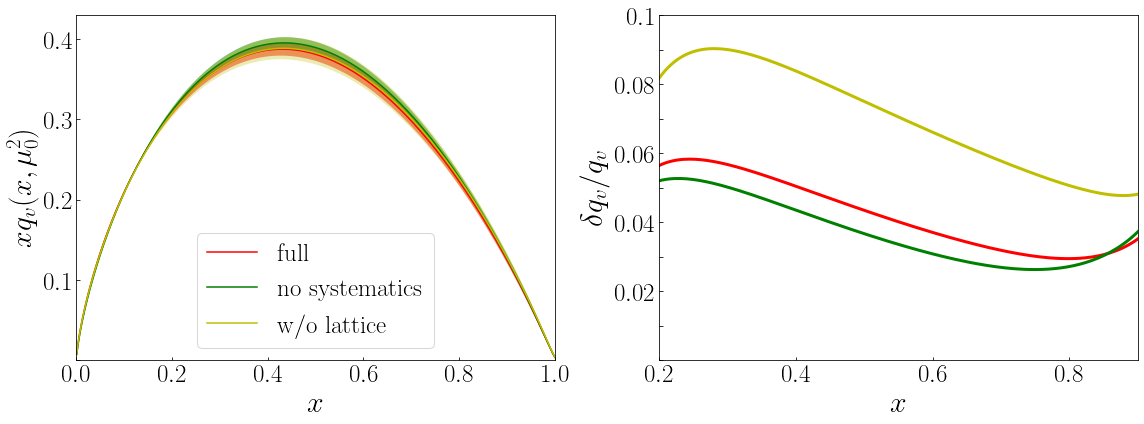

In [50]:
nrows,ncols=1,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0),'r',label=r'$\rm full$')
ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0)-np.std(newpdf['XF']['valence'],axis=0),np.mean(newpdf['XF']['valence'],axis=0)+np.std(newpdf['XF']['valence'],axis=0),alpha=0.5,fc='r')
ax.plot(midpdf['X'],np.mean(midpdf['XF']['valence'],axis=0),'g',label=r'$\rm no~systematics$')
ax.fill_between(midpdf['X'],np.mean(midpdf['XF']['valence'],axis=0)-np.std(midpdf['XF']['valence'],axis=0),np.mean(midpdf['XF']['valence'],axis=0)+np.std(midpdf['XF']['valence'],axis=0),alpha=0.5,fc='g')
ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0),'y',label=r'$\rm w/o~lattice$')
ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0)-np.std(oldpdf['XF']['valence'],axis=0),np.mean(oldpdf['XF']['valence'],axis=0)+np.std(oldpdf['XF']['valence'],axis=0),alpha=0.3,fc='y')
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xq_v(x,\mu_0^2)$',size=30)
ax.set_xlim(0,1)
ax.set_ylim(0,0.43)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
ax.legend(fontsize=25)
ax.tick_params(direction='in',which='both',labelsize=25)

ax=py.subplot(nrows,ncols,2)
ax.plot(newpdf['X'],np.std(newpdf['XF']['valence'],axis=0)/newpdf['X']/np.mean(newpdf['XF']['valence'],axis=0),'r',lw=3)
ax.plot(midpdf['X'],np.std(midpdf['XF']['valence'],axis=0)/midpdf['X']/np.mean(midpdf['XF']['valence'],axis=0),'g',lw=3)
ax.plot(oldpdf['X'],np.std(oldpdf['XF']['valence'],axis=0)/oldpdf['X']/np.mean(oldpdf['XF']['valence'],axis=0),'y',lw=3)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$\delta q_v/q_v$',size=30)
ax.set_ylim(0,0.1)
ax.set_xlim(0.2,0.9)
# ax.semilogy()
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
ax.set_yticklabels(['','',r'$0.02$','',r'$0.04$','',r'$0.06$','',r'$0.08$','',r'$0.1$'])

ax.tick_params(direction='in',which='both',labelsize=25)

py.tight_layout()
# py.savefig('new_gallery/pdfval_comp_pITD_syst_P1_full_wolattice.png')

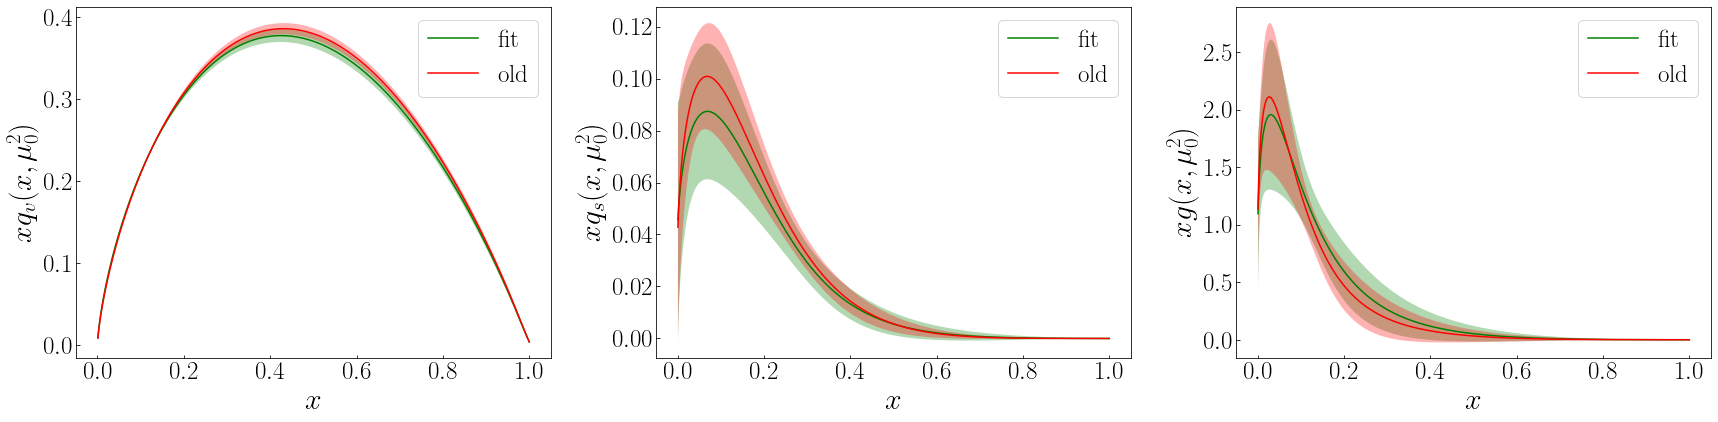

In [92]:
nrows,ncols=1,3
# nrows,ncols=3,2
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0),'g',label=r'$\rm fit$')
ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0)-np.std(newpdf['XF']['valence'],axis=0),np.mean(newpdf['XF']['valence'],axis=0)+np.std(newpdf['XF']['valence'],axis=0),alpha=0.3,fc='g')
ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0),'r',label=r'$\rm old$')
ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0)-np.std(oldpdf['XF']['valence'],axis=0),np.mean(oldpdf['XF']['valence'],axis=0)+np.std(oldpdf['XF']['valence'],axis=0),alpha=0.3,fc='r')
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xq_v(x,\mu_0^2)$',size=30)
ax.legend(fontsize=25)
ax.tick_params(direction='in',which='both',labelsize=25)

# ax=py.subplot(nrows,ncols,2)
# ax.plot(newpdf['X'],np.std(newpdf['XF']['valence'],axis=0)/np.std(oldpdf['XF']['valence'],axis=0),lw=3)
# ax.set_xlabel(r'$x$',size=30)
# ax.set_ylabel(r'$\delta q_v~/~q_v$',size=30)
# ax.tick_params(direction='in',which='both',labelsize=25)

ax=py.subplot(nrows,ncols,2)
ax.plot(newpdf['X'],np.mean(newpdf['XF']['sea'],axis=0),'g',label=r'$\rm fit$')
ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['sea'],axis=0)-np.std(newpdf['XF']['sea'],axis=0),np.mean(newpdf['XF']['sea'],axis=0)+np.std(newpdf['XF']['sea'],axis=0),alpha=0.3,fc='g')
ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['sea'],axis=0),'r',label=r'$\rm old$')
ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['sea'],axis=0)-np.std(oldpdf['XF']['sea'],axis=0),np.mean(oldpdf['XF']['sea'],axis=0)+np.std(oldpdf['XF']['sea'],axis=0),alpha=0.3,fc='r')
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xq_s(x,\mu_0^2)$',size=30)
ax.legend(fontsize=25)
ax.tick_params(direction='in',which='both',labelsize=25)

# ax=py.subplot(nrows,ncols,4)
# ax.plot(newpdf['X'],np.std(newpdf['XF']['sea'],axis=0)/np.std(oldpdf['XF']['sea'],axis=0),lw=3)
# ax.set_xlabel(r'$x$',size=30)
# ax.set_ylabel(r'$\delta q_s~/~q_s$',size=30)
# ax.tick_params(direction='in',which='both',labelsize=25)

ax=py.subplot(nrows,ncols,3)
ax.plot(newpdf['X'],np.mean(newpdf['XF']['g'],axis=0),'g',label=r'$\rm fit$')
ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['g'],axis=0)-np.std(newpdf['XF']['g'],axis=0),np.mean(newpdf['XF']['g'],axis=0)+np.std(newpdf['XF']['g'],axis=0),alpha=0.3,fc='g')
ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['g'],axis=0),'r',label=r'$\rm old$')
ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['g'],axis=0)-np.std(oldpdf['XF']['g'],axis=0),np.mean(oldpdf['XF']['g'],axis=0)+np.std(oldpdf['XF']['g'],axis=0),alpha=0.3,fc='r')
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xg(x,\mu_0^2)$',size=30)
ax.legend(fontsize=25)
ax.tick_params(direction='in',which='both',labelsize=25)

# ax=py.subplot(nrows,ncols,6)
# ax.plot(newpdf['X'],np.std(newpdf['XF']['g'],axis=0)/np.std(oldpdf['XF']['g'],axis=0),lw=3)
# ax.set_xlabel(r'$x$',size=30)
# ax.set_ylabel(r'$\delta g~/~g$',size=30)
# ax.tick_params(direction='in',which='both',labelsize=25)

py.tight_layout()
# py.savefig('%s/gallery/pdfall_comp.png'%wdir)

# Parameters

In [28]:
def par_histogram(wdir,param):
#     istep=core.get_istep()
    istep=17
    replicas=core.get_replicas(wdir)
    par=[]
    for i in range(len(replicas)):
        order=replicas[i]['order'][istep]
        for j in range(len(order)):
            if order[j][2]==param:
                par.append(replicas[i]['params'][istep][j])
    par=np.array(par)
    
    ax=py.subplot(111)
    ax.hist(par,bins=25)
    ax.tick_params(direction='in',which='both',labelsize=20)
    ax.set_title(r'${\rm %s}$'%param,size=30)
    
    py.tight_layout()
    checkdir('%s/gallery'%wdir)
    py.savefig('%s/gallery/histogram-%s.png'%(wdir,param))


In [58]:
wdirpITD[0]

'/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1allz/'

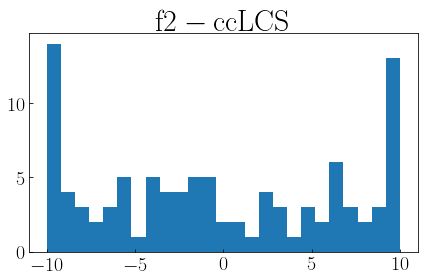

In [29]:
# for w in wdirs:
#     par_histogram(w,'cL-pITD')
# par_histogram(wdirpITD[0],'p1-pITD')
par_histogram(wdirsccLCS[0],'f2-ccLCS')
# par_histogram(wdirs[2],'cL-ccLCS')
# par_histogram(wdirs[2],'b1-mpi')
# par_histogram(wdirs[2],'b2-a')/work/

In [66]:
def par_2d_scatter(wdir,param):
    istep=core.get_istep()
    replicas=core.get_replicas(wdir)

    order=replicas[0]['order'][istep]
    passive=conf['steps'][istep]['passive distributions']
    neworder=[]
    for i in range(len(order)): 
        flag=False
        for k in passive:
            if k==order[i][1]: flag=True
        if flag: continue
        else: neworder.append(order[i])

    nrows,ncols=4,math.ceil(len(neworder)/4)
    cnt=0
    py.figure(figsize=(4*ncols,4*nrows))

    
    par=[]
    for i in range(len(replicas)):
        for j in range(len(neworder)):
            if order[j][2]==param:
                par.append(replicas[i]['params'][istep][j])

    for i in range(len(neworder)): 
        cnt+=1
        par2=[]
        ax=py.subplot(nrows,ncols,cnt)
        for j in range(len(replicas)):
            par2.append(replicas[j]['params'][istep][i])
        ax.scatter(par,par2,label=r'$\rm %s$'%order[i][2])
        ax.legend(fontsize=20)
        ax.tick_params(direction='in',which='both',labelsize=20)
        if i==0: ax.set_title(r'${\rm %s}$'%param,size=30)
    
    py.tight_layout()
#     checkdir('%s/gallery'%wdir)
#     py.savefig('%s/gallery/histogram-%s.png'%(wdir,param))


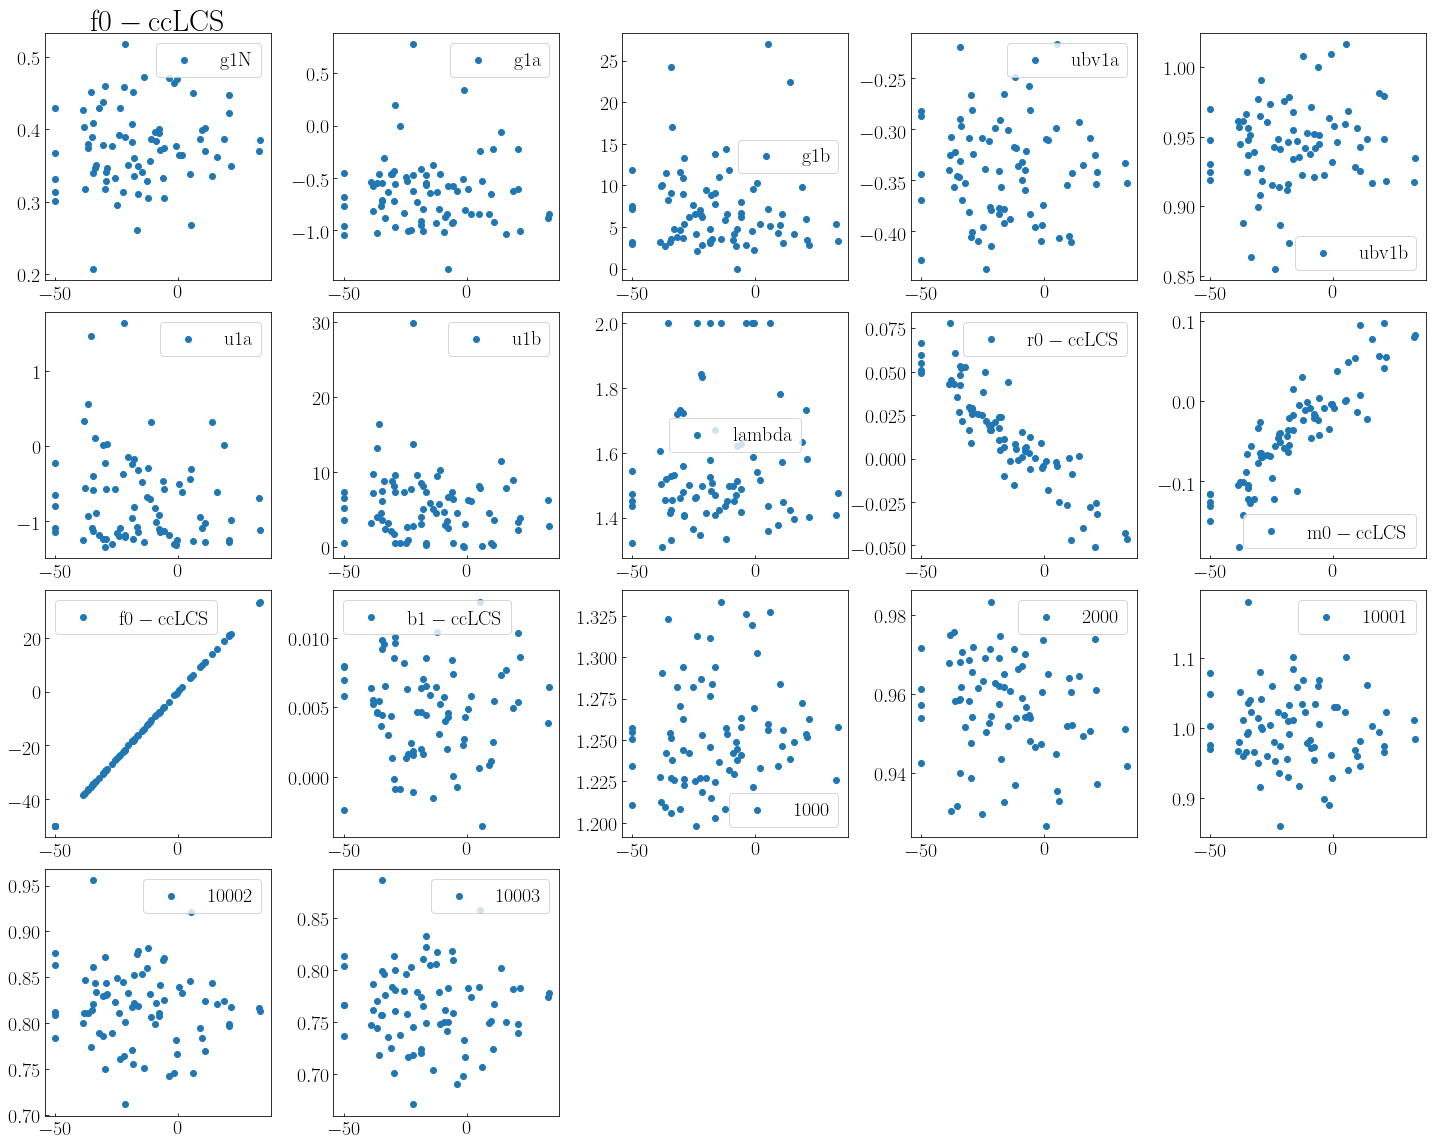

In [70]:
# par_2d_scatter(wdirsccLCS[1],'f0-ccLCS')
par_2d_scatter('/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/systematics/R0M0B1F0/','f0-ccLCS')

# PDF moments

In [93]:
def gen_pdf_moments(wdir,Q2=None):
    load_config('%s/input.py'%wdir)
    istep=core.get_istep()
    replicas=core.get_replicas(wdir)
#     rep=replicas[0]
#     repname=os.listdir('%s/msr-inspected/'%wdir)[0]

    core.mod_conf(istep,replicas[0])
    order=replicas[0]['order'][istep]

    conf['bootstrap']=False
    
    resman=RESMAN(nworkers=10,parallel=True,datasets=True)
    parman=resman.parman
    
    pdf=conf['pdf-pion']

    if Q2==None: Q2=conf['Q20']
    mom1={} #--<x>
    mom2={} #--<x**2>
    mom3={} #--<x**3>
    mom4={} #--<x**4>

    for i in range(len(replicas)):
        rep=replicas[i]
        lprint('progress: %i/%i'%(i+1,len(replicas)))

        parman.order=rep['order'][istep]
        parman.set_new_params(rep['params'][istep])

        for flav in ['valence','sea','g']:
            if flav not in mom1: mom1[flav]=[]
            if flav not in mom2: mom2[flav]=[]
            if flav not in mom3: mom3[flav]=[]
            if flav not in mom4: mom4[flav]=[]

            if flav=='valence':
                func=lambda x: pdf.get_xF(x,Q2,'ub')-pdf.get_xF(x,Q2,'u')
            elif flav=='sea':
                func=lambda x: pdf.get_xF(x,Q2,'u')
            else:
                func=lambda x: pdf.get_xF(x,Q2,'g')

            mom1[flav].append(quad(lambda x: func(x),0,1)[0])
            mom2[flav].append(quad(lambda x: x*func(x),0,1)[0])
            mom3[flav].append(quad(lambda x: x**2*func(x),0,1)[0])
            mom4[flav].append(quad(lambda x: x**3*func(x),0,1)[0])


    resman.shutdown()
    
    checkdir('%s/data'%wdir)
    save({'Q2':Q2,'mom1':mom1,'mom2':mom2,'mom3':mom3,'mom4':mom4},'%s/data/pdf-mom-%d.dat'%(wdir,istep))

In [94]:
for i in range(len(wdirs)):
    gen_pdf_moments(wdirs[i])

loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
loading ccLCS data sets 12781
loading ccLCS data sets 13581
loading ccLCS data sets 14131
loading ccLCS data sets 14132
progress: 200/200loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
loading ccLCS data sets 12781
loading ccLCS data sets 13581
loading ccLCS data sets 14131
loading ccLCS data sets 14132
progress: 200/200loading dy-pion data sets 10001
loading dy-pion data

In [95]:
for i in range(len(wdirs2)):
    gen_pdf_moments(wdirs2[i])

loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
loading ccLCS data sets 12781
loading ccLCS data sets 13581
loading ccLCS data sets 14131
loading ccLCS data sets 14132
progress: 200/200

In [99]:
mom=load('%s/data/pdf-mom-17.dat'%wdirs2[0])
# mom=load('%s/data/pdf-mom-18.dat'%wdirs[2])
# mom=load('%s/data/pdf-mom-19.dat'%wdir)

In [100]:
valmom1=2*np.mean(mom['mom1']['valence'],axis=0)
dvalmom1=2*np.std(mom['mom1']['valence'],axis=0)
print(valmom1)
seamom1=6*np.mean(mom['mom1']['sea'],axis=0)
dseamom1=6*np.std(mom['mom1']['sea'],axis=0)
print(seamom1)
glumom1=np.mean(mom['mom1']['g'],axis=0)
dglumom1=np.std(mom['mom1']['g'],axis=0)
print(glumom1)

0.5377664767554232
0.15286693640909818
0.30941614753830055


In [101]:
print('<x>_val = %.2f +/- %.3f'%(valmom1,dvalmom1))
print('<x>_sea = %.2f +/- %.3f'%(seamom1,dseamom1))
print('<x>_g   = %.2f +/- %.3f'%(glumom1,dglumom1))


<x>_val = 0.54 +/- 0.007
<x>_sea = 0.15 +/- 0.024
<x>_g   = 0.31 +/- 0.027


In [37]:
def gen_b_eff(wdir,Q2=None):
    load_config('%s/input.py'%wdir)
    istep=core.get_istep()
    replicas=core.get_replicas(wdir)
#     rep=replicas[0]
#     repname=os.listdir('%s/msr-inspected/'%wdir)[0]

    core.mod_conf(istep,replicas[0])
    order=replicas[0]['order'][istep]

    conf['bootstrap']=False
    
    resman=RESMAN(nworkers=10,parallel=True,datasets=True)
    parman=resman.parman
    
    pdf=conf['pdf-pion']

    X=np.linspace(0.75,0.99,100)

    b_eff=[]
    cnt=0
    for i in range(len(replicas)):
        rep=replicas[i]
        lprint('progress: %i/%i'%(i+1,len(replicas)))

        parman.order=rep['order'][istep]
        parman.set_new_params(rep['params'][istep])

        flav='ubv1'
        M,a,b,c,d=pdf.params[flav]
        b_eff.append([b-a*(1-x)/x-c*d*x**(d-1)*(1-x)/(1+c*x**d) for x in X])


    resman.shutdown()
    
    checkdir('%s/data'%wdir)
    save({'X':X,'b_eff':b_eff},'%s/data/b_eff-%d.dat'%(wdir,istep))

In [38]:
gen_b_eff(wdir)
# gen_b_eff('/work/JAM/barryp/JAM/analysis-pITD/NLOpy3/')

loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
progress: 197/197

In [41]:
# beffnew=load('%s/data/b_eff-17.dat'%wdir)
beffnew=load('%s/data/b_eff-18.dat'%wdir)
# beffnew=load('%s/data/b_eff-19.dat'%wdir)
beffold=load('/work/JAM/barryp/JAM/analysis-LCS/NLOpy3/data/b_eff-16.dat')
# beffold=load('/work/JAM/barryp/JAM/analysis-pITD/NLLpy3_cosine/data/b_eff-18.dat')

In [42]:
beffmean=np.mean(beffnew['b_eff'],axis=0)
beffstd=np.std(beffnew['b_eff'],axis=0)

oldbeffmean=np.mean(beffold['b_eff'],axis=0)
oldbeffstd=np.std(beffold['b_eff'],axis=0)

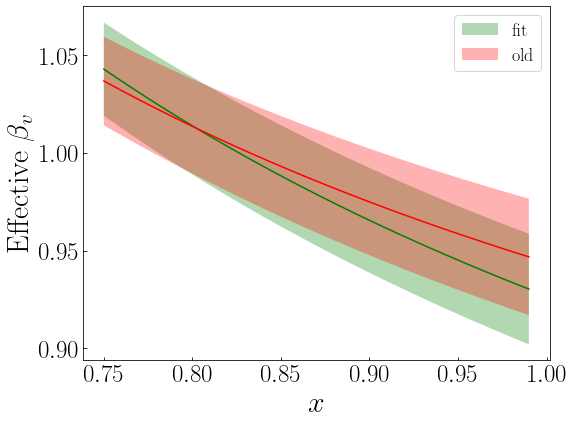

In [43]:
nrows,ncols=1,1
py.figure(figsize=(8*ncols,6*nrows))

ax=py.subplot(nrows,ncols,1)
ax.plot(beffnew['X'],beffmean,c='g')
ax.fill_between(beffnew['X'],beffmean-beffstd,beffmean+beffstd,alpha=0.3,fc='g',label=r'$\rm fit$')

ax.plot(beffold['X'],oldbeffmean,c='r')
ax.fill_between(beffold['X'],oldbeffmean-oldbeffstd,oldbeffmean+oldbeffstd,alpha=0.3,fc='r',label=r'$\rm old$')

ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'${\rm Effective~} \beta_v $',size=30)

ax.legend(fontsize=18)
ax.tick_params(direction='in',which='both',labelsize=25)

# ax.set_ylim(0.5,2.7)
py.tight_layout()
checkdir('%s/gallery'%wdir)
py.savefig('%s/gallery/b_eff.png'%wdir)

# Lattice Systematics - hard wire in parameters

In [49]:
p=load('%s/data/predictions-17.dat'%wdirs[0])
# p=load('%s/data/predictions-19.dat'%wdir)

In [50]:
def data_over_theorypITD_mod(predictions,wdir):
    zunique=np.unique(predictions['reactions']['pITD'][1001]['ZoA'])
    nrows=len(predictions['reactions']['pITD'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['pITD']:
        p=predictions['reactions']['pITD'][k]
        #--mod
        L=p['L']
        a=p['a']
        mpi=p['mpi']
        z=p['z']
        z=5*z #--GeV^-1
        nu=p['nu']
        mpiGeV=1e-3*mpi
        LGeVinv=5*L*a
        FV=0
        for i in range(len(p['prediction-rep'])):
            p['prediction-rep'][i]+=FV*np.exp(-mpiGeV*(LGeVinv-z))
        #--get chi2
        c=[x for x in p if 'cov' in x]
        cov=np.zeros((len(c),len(c)))
        for i in range(len(c)):
            cov[i]=p[c[i]]
        covinv=np.linalg.inv(cov)
        vect=p['value']-np.mean(p['prediction-rep'],axis=0)
        chi2=np.einsum('i,ij,j',vect,covinv,vect)
        print(chi2)
        npts=len(vect)
        
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
            ax.errorbar(nu,vals/meanthy,yerr=alphas/meanthy,fmt='.',label=r'$z=%i a$'%zunique[i])
            ax.axhline(y=1,color='k',alpha=0.5)
            ax.fill_between(nu,1-stdthy/meanthy,1+stdthy/meanthy,alpha=0.3,fc='y')
            ax.set_ylim(0.99,1.01)
            ax.set_yticks([0.99,0.995,1,1.005,1.01])
            if i==0:
                ax.set_yticklabels([r'$0.99$','',r'$1$','',r'$1.01$'])
            else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
            if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
            ax.legend(fontsize=25,loc='upper left')#,frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
            if i==0: ax.text(0.1,0.3,r'$L=%i$'%p['L'][0],transform=ax.transAxes,size=30)
            if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/data_over_theory_pITD.png'%wdir)

In [51]:
def data_over_theoryccLCS_mod(predictions,wdir):
    zunique=np.unique(predictions['reactions']['ccLCS'][12781]['ZoA'])
    nrows=len(predictions['reactions']['ccLCS'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['ccLCS']:
        p=predictions['reactions']['ccLCS'][k]
        
        #--mod
        L=p['L']
        a=p['a']
        mpi=p['mpi']
        z=p['z']
        z=5*z #--GeV^-1
        nu=p['nu']
        mpiGeV=1e-3*mpi
        LGeVinv=5*L*a
        FV=0.102
        b1=0.174
        b2=-0.083
#         FV=0
#         b1=0
#         b2=0
        for i in range(len(p['prediction-rep'])):
            p['prediction-rep'][i]+=FV*np.exp(-mpiGeV*(LGeVinv-z))
            p['prediction-rep'][i]+=b1*(mpiGeV-0.13803)
            p['prediction-rep'][i]+=b2*a*5 #--units

        #--get chi2
        thy=np.mean(p['prediction-rep'],axis=0)
        res=(p['value']-thy)/p['alpha']
        chi2=np.sum(res**2)
        print(chi2)
        npts=len(res)
                
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
            ax.errorbar(nu,vals/meanthy,yerr=alphas/meanthy,fmt='.',label=r'$z=%i a$'%zunique[i])
            ax.axhline(y=1,color='k',alpha=0.5)
            ax.fill_between(nu,1-stdthy/meanthy,1+stdthy/meanthy,alpha=0.3,fc='y')
            ax.set_ylim(0.5,1.5)
            ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5])
            if i==0:
                ax.set_yticklabels(['',r'$0.6$','',r'$0.8$','',r'$1$','',r'$1.2$','',r'$1.4$',''])
            else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
            if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
            ax.legend(fontsize=25,loc='upper left')#,frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
            if i==0: ax.text(0.1,0.3,r'$L=%i a$'%p['L'][0],transform=ax.transAxes,size=25)
            if i==0: ax.text(0.1,0.18,r'$m_\pi=%i~{\rm MeV}$'%p['mpi'][0],transform=ax.transAxes,size=25)
            if i==0: ax.text(0.1,0.06,r'$a=%.3f~{\rm fm}$'%p['a'][0],transform=ax.transAxes,size=25)
            if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('new_gallery')
    py.savefig('new_gallery/data_over_theoryccLCS_mod.png')

54.00108740534824
11.830118143255984
30.169776393703216
36.849795359815914


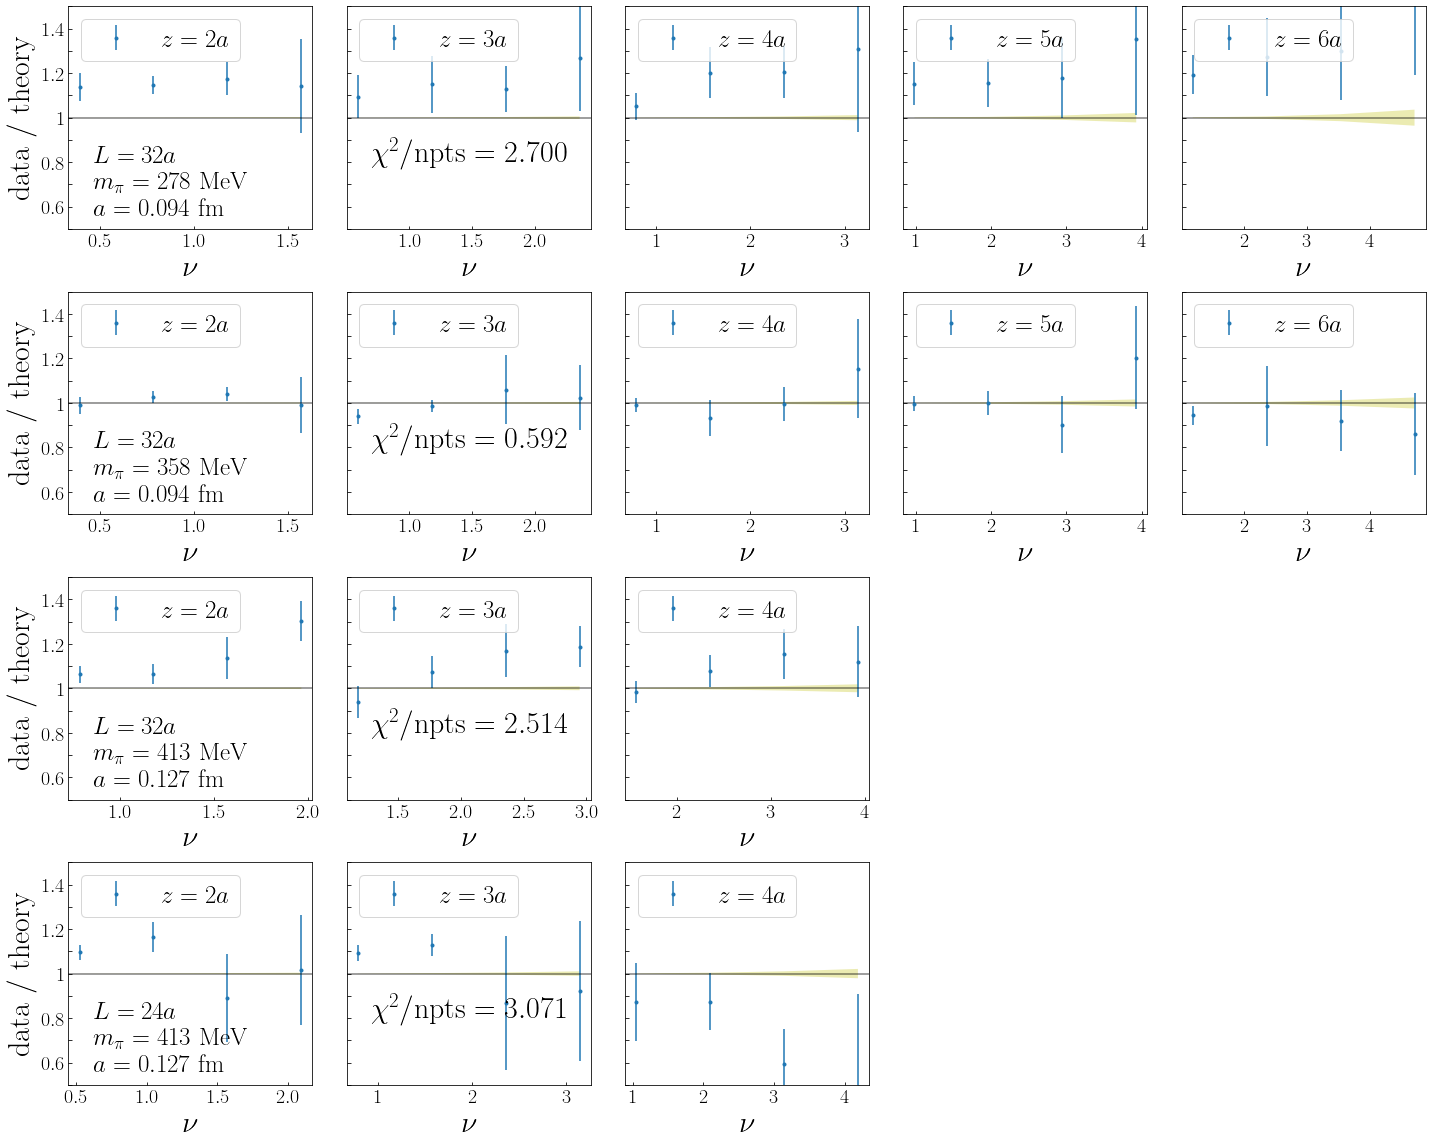

In [52]:
data_over_theoryccLCS_mod(p,wdirs[0])

# Data and Theory

In [38]:
def data_and_theorypITD(predictions,wdir):
    zunique=np.unique(predictions['reactions']['pITD'][1001]['ZoA'])
    nrows=len(predictions['reactions']['pITD'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['pITD']:
        p=predictions['reactions']['pITD'][k]
        #--get chi2
        c=[x for x in p if 'cov' in x]
        cov=np.zeros((len(c),len(c)))
        for i in range(len(c)):
            cov[i]=p[c[i]]
        covinv=np.linalg.inv(cov)
        vect=p['value']-np.mean(p['prediction-rep'],axis=0)
        chi2=np.einsum('i,ij,j',vect,covinv,vect)
        print(chi2)
        npts=len(vect)
        
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
            ax.errorbar(nu,vals,yerr=alphas,fmt='.')
#             ax.axhline(y=1,color='k',alpha=0.5)
            ax.fill_between(nu,meanthy-stdthy,meanthy+stdthy,alpha=0.3,fc='r',ec='r')
#             ax.set_ylim(0.99,1.01)
#             ax.set_yticks([0.99,0.995,1,1.005,1.01])
#             if i==0:
#                 ax.set_yticklabels([r'$0.99$','',r'$1$','',r'$1.01$'])
#             else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
#             if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
#             ax.legend(fontsize=25,loc='upper left')#,frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
#             if i==0: ax.text(0.1,0.3,r'$L=%i$'%p['L'][0],transform=ax.transAxes,size=30)
#             if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/data_and_theory_pITD.png'%wdir)

In [39]:
def data_and_theorypITD2(predictions,predictionsnosys,wdir):
    zunique=np.unique(predictions['reactions']['pITD'][1001]['ZoA'])
    nrows=len(predictions['reactions']['pITD'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['pITD']:
        p=predictions['reactions']['pITD'][k]
        pns=predictionsnosys['reactions']['pITD'][k]
        #--get chi2
        c=[x for x in p if 'cov' in x]
        cov=np.zeros((len(c),len(c)))
        for i in range(len(c)):
            cov[i]=p[c[i]]
        covinv=np.linalg.inv(cov)
        vect=p['value']-np.mean(p['prediction-rep'],axis=0)
        chi2=np.einsum('i,ij,j',vect,covinv,vect)
        print(chi2)
        npts=len(vect)
        
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            theorynosys=np.mean(pns['prediction-rep'],axis=0)
            dtheorynosys=np.std(pns['prediction-rep'],axis=0)
#             theorysys=np.mean(np.array(p['prediction-rep'])-np.array(pns['prediction-rep']),axis=0)
#             dtheorysys=np.std(np.array(p['prediction-rep'])-np.array(pns['prediction-rep']),axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            meanthynosys=[]
            stdthynosys=[]
            meanthysys=[]
            stdthysys=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
                    meanthynosys.append(theorynosys[j])
                    stdthynosys.append(dtheorynosys[j])
#                     meanthysys.append(theorysys[j])
#                     stdthysys.append(dtheorysys[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            meanthynosys=np.array(meanthynosys)
            stdthynosys=np.array(stdthynosys)
#             meanthysys=np.array(meanthysys)
#             stdthysys=np.array(stdthysys)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
            ax.errorbar(nu,vals,yerr=alphas,fmt='.')
#             ax.axhline(y=1,color='k',alpha=0.5)
            ax.fill_between(nu,meanthy-stdthy,meanthy+stdthy,alpha=0.3,fc='r',ec='r',label=r'$\rm full$')
            ax.fill_between(nu,meanthynosys-stdthynosys,meanthynosys+stdthynosys,alpha=0.3,fc='g',ec='g',label=r'$\rm no~sys$')
#             ax.fill_between(nu,meanthysys-stdthysys,meanthysys+stdthysys,alpha=0.3,fc='y',ec='slategrey')
#             ax.set_ylim(0.99,1.01)
#             ax.set_yticks([0.99,0.995,1,1.005,1.01])
#             if i==0:
#                 ax.set_yticklabels([r'$0.99$','',r'$1$','',r'$1.01$'])
#             else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
#             if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
            ax.legend(fontsize=20,loc='lower left',frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
#             if i==0: ax.text(0.1,0.3,r'$L=%i$'%p['L'][0],transform=ax.transAxes,size=30)
#             if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/data_and_theory_pITD_syst.png'%wdir)

In [40]:
def data_and_theorypITD3(predictions,predictionsnosys,predictionsexp,wdir):
    zunique=np.unique(predictions['reactions']['pITD'][1001]['ZoA'])
    nrows=len(predictions['reactions']['pITD'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['pITD']:
        p=predictions['reactions']['pITD'][k]
        pns=predictionsnosys['reactions']['pITD'][k]
        pex=predictionsexp['reactions']['pITD'][k]
        #--get chi2
        c=[x for x in p if 'cov' in x]
        cov=np.zeros((len(c),len(c)))
        for i in range(len(c)):
            cov[i]=p[c[i]]
        covinv=np.linalg.inv(cov)
        vect=p['value']-np.mean(p['prediction-rep'],axis=0)
        chi2=np.einsum('i,ij,j',vect,covinv,vect)
        print(chi2)
        npts=len(vect)
        
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            theorynosys=np.mean(pns['prediction-rep'],axis=0)
            dtheorynosys=np.std(pns['prediction-rep'],axis=0)
            theoryexp=np.mean(pex['prediction-rep'],axis=0)
            dtheoryexp=np.std(pex['prediction-rep'],axis=0)
#             theorysys=np.mean(np.array(p['prediction-rep'])-np.array(pns['prediction-rep']),axis=0)
#             dtheorysys=np.std(np.array(p['prediction-rep'])-np.array(pns['prediction-rep']),axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            meanthynosys=[]
            stdthynosys=[]
            meanthyexp=[]
            stdthyexp=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
                    meanthynosys.append(theorynosys[j])
                    stdthynosys.append(dtheorynosys[j])
                    meanthyexp.append(theoryexp[j])
                    stdthyexp.append(dtheoryexp[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            meanthynosys=np.array(meanthynosys)
            stdthynosys=np.array(stdthynosys)
            meanthyexp=np.array(meanthyexp)
            stdthyexp=np.array(stdthyexp)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
            ax.errorbar(nu,vals,yerr=alphas,fmt='.')
#             ax.axhline(y=1,color='k',alpha=0.5)
            ax.fill_between(nu,meanthy-stdthy,meanthy+stdthy,alpha=0.3,fc='r',ec='r',label=r'$\rm full$')
            ax.fill_between(nu,meanthynosys-stdthynosys,meanthynosys+stdthynosys,alpha=0.3,fc='g',ec='g',label=r'$\rm no~sys$')
            ax.fill_between(nu,meanthyexp-stdthyexp,meanthyexp+stdthyexp,alpha=0.3,fc='y',ec='slategrey',label=r'$\rm pred~expt$')
#             ax.set_ylim(0.99,1.01)
#             ax.set_yticks([0.99,0.995,1,1.005,1.01])
#             if i==0:
#                 ax.set_yticklabels([r'$0.99$','',r'$1$','',r'$1.01$'])
#             else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
#             if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
            ax.legend(fontsize=20,loc='lower left',frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
#             if i==0: ax.text(0.1,0.3,r'$L=%i$'%p['L'][0],transform=ax.transAxes,size=30)
#             if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/data_and_theory_pITD_syst_exp.png'%wdir)

19.69782703522685
18.628700618325013


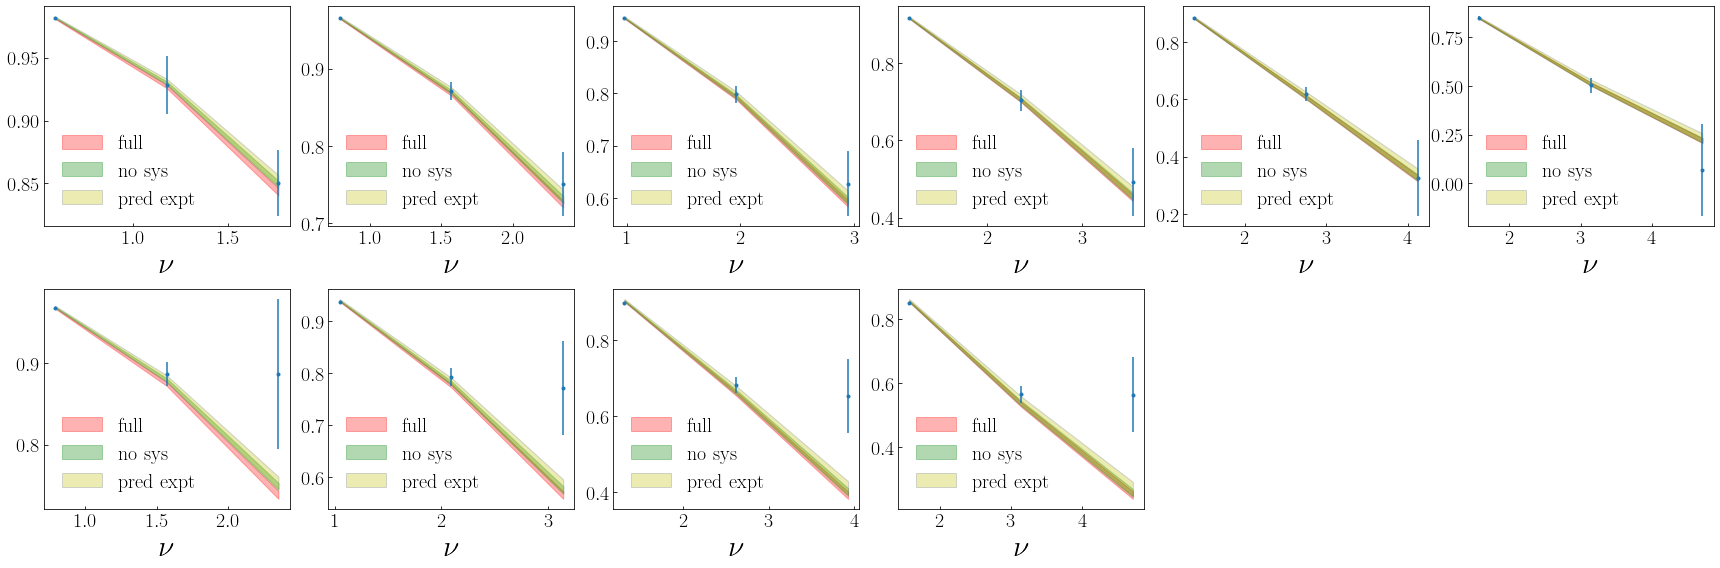

In [41]:
# w='/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/'
# data_and_theorypITD2(load('%s/data/predictions-17.dat'%w),load('%s/data/predictions-17-mod.dat'%w),w)
w2='/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/'
w3='/work/JAM/barryp/JAM/analysis-LCS/pITD/pITDnlo_allp/'
# data_and_theorypITD3(load('%s/data/predictions-17.dat'%w2),load('%s/data/predictions-17-mod.dat'%w2),load('%s/data/predictions-LCS-16.dat'%w),w2)
data_and_theorypITD3(load('%s/data/predictions-17.dat'%w2),load('%s/data/predictions-17.dat'%w3),load('%s/data/predictions-LCS-16.dat'%w),w2)

In [42]:
def uncpITD3(predictions,predictionsnosys,predictionsexp,wdir):
    zunique=np.unique(predictions['reactions']['pITD'][1001]['ZoA'])
    nrows=len(predictions['reactions']['pITD'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['pITD']:
        p=predictions['reactions']['pITD'][k]
        pns=predictionsnosys['reactions']['pITD'][k]
        pex=predictionsexp['reactions']['pITD'][k]
        #--get chi2
        c=[x for x in p if 'cov' in x]
        cov=np.zeros((len(c),len(c)))
        for i in range(len(c)):
            cov[i]=p[c[i]]
        covinv=np.linalg.inv(cov)
        vect=p['value']-np.mean(p['prediction-rep'],axis=0)
        chi2=np.einsum('i,ij,j',vect,covinv,vect)
        print(chi2)
        npts=len(vect)
        
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            theorynosys=np.mean(pns['prediction-rep'],axis=0)
            dtheorynosys=np.std(pns['prediction-rep'],axis=0)
            theoryexp=np.mean(pex['prediction-rep'],axis=0)
            dtheoryexp=np.std(pex['prediction-rep'],axis=0)
#             theorysys=np.mean(np.array(p['prediction-rep'])-np.array(pns['prediction-rep']),axis=0)
#             dtheorysys=np.std(np.array(p['prediction-rep'])-np.array(pns['prediction-rep']),axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            meanthynosys=[]
            stdthynosys=[]
            meanthyexp=[]
            stdthyexp=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
                    meanthynosys.append(theorynosys[j])
                    stdthynosys.append(dtheorynosys[j])
                    meanthyexp.append(theoryexp[j])
                    stdthyexp.append(dtheoryexp[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            meanthynosys=np.array(meanthynosys)
            stdthynosys=np.array(stdthynosys)
            meanthyexp=np.array(meanthyexp)
            stdthyexp=np.array(stdthyexp)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
#             ax.errorbar(nu,vals,yerr=alphas,fmt='.')
#             ax.axhline(y=1,color='k',alpha=0.5)
#             ax.fill_between(nu,meanthy-stdthy,meanthy+stdthy,alpha=0.3,fc='r',ec='r',label=r'$\rm full$')
#             ax.fill_between(nu,meanthynosys-stdthynosys,meanthynosys+stdthynosys,alpha=0.3,fc='g',ec='g',label=r'$\rm no~sys$')
#             ax.fill_between(nu,meanthyexp-stdthyexp,meanthyexp+stdthyexp,alpha=0.3,fc='y',ec='slategrey',label=r'$\rm pred~expt$')
            ax.plot(nu,stdthy,c='r',label=r'$\rm full$')
            ax.plot(nu,stdthynosys,c='g',label=r'$\rm no~sys$')
            ax.plot(nu,stdthyexp,c='y',label=r'$\rm pred~expt$')
#             ax.set_ylim(0.99,1.01)
#             ax.set_yticks([0.99,0.995,1,1.005,1.01])
            if i==0:
                ax.set_ylabel(r'$\delta$',size=30)
#                 ax.set_yticklabels([r'$0.99$','',r'$1$','',r'$1.01$'])
#             else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
#             if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
            ax.legend(fontsize=20,loc='upper left',frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
#             if i==0: ax.text(0.1,0.3,r'$L=%i$'%p['L'][0],transform=ax.transAxes,size=30)
#             if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/unc_pITD_syst_exp.png'%wdir)

19.69782703522685
18.628700618325013


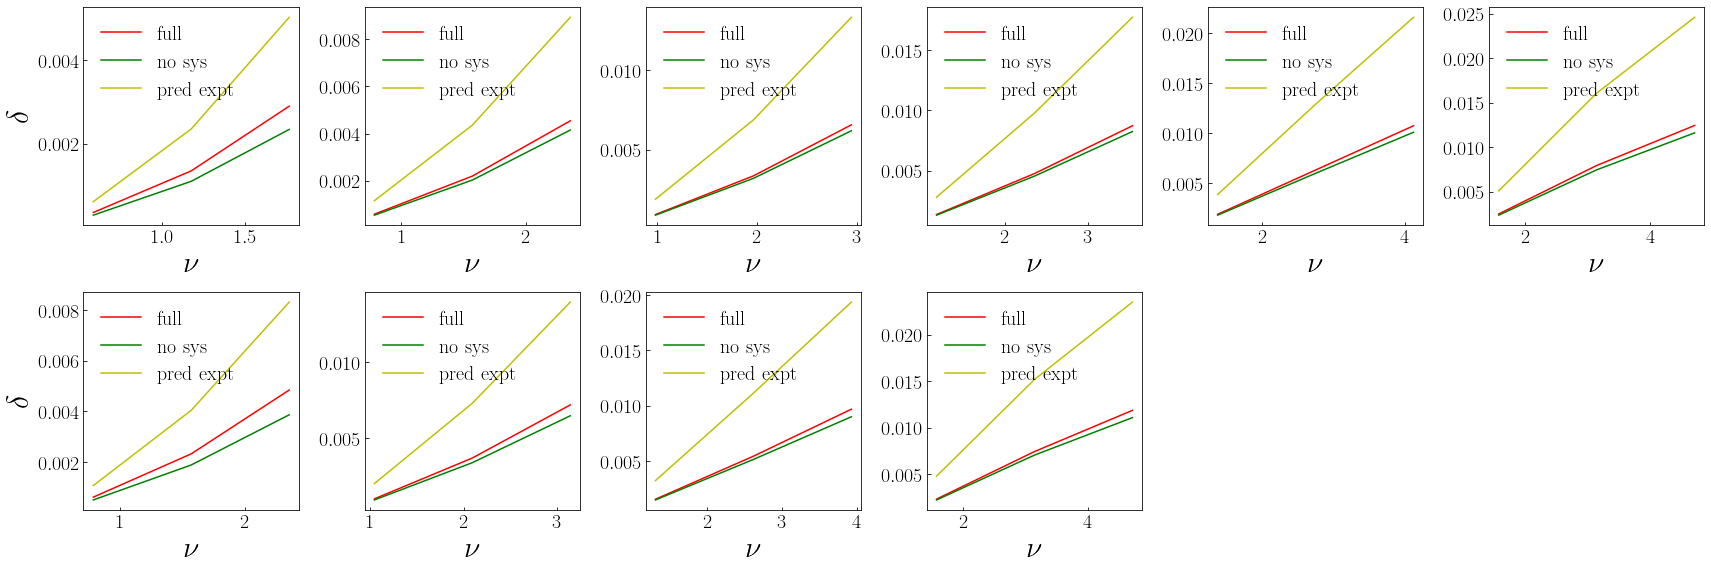

In [43]:
# w='/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/'
# data_and_theorypITD2(load('%s/data/predictions-17.dat'%w),load('%s/data/predictions-17-mod.dat'%w),w)
w2='/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/'
uncpITD3(load('%s/data/predictions-17.dat'%w2),load('%s/data/predictions-17.dat'%w3),load('%s/data/predictions-LCS-16.dat'%w),w)

In [46]:
def uncpITD2(predictions,predictionsexp,wdir):
    zunique=np.unique(predictions['reactions']['pITD'][1001]['ZoA'])
    nrows=len(predictions['reactions']['pITD'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['pITD']:
        p=predictions['reactions']['pITD'][k]
        pex=predictionsexp['reactions']['pITD'][k]
        #--get chi2
        c=[x for x in p if 'cov' in x]
        cov=np.zeros((len(c),len(c)))
        for i in range(len(c)):
            cov[i]=p[c[i]]
        covinv=np.linalg.inv(cov)
        vect=p['value']-np.mean(p['prediction-rep'],axis=0)
        chi2=np.einsum('i,ij,j',vect,covinv,vect)
        print(chi2)
        npts=len(vect)
        
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            theoryexp=np.mean(pex['prediction-rep'],axis=0)
            dtheoryexp=np.std(pex['prediction-rep'],axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            meanthyexp=[]
            stdthyexp=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
                    meanthyexp.append(theoryexp[j])
                    stdthyexp.append(dtheoryexp[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            meanthyexp=np.array(meanthyexp)
            stdthyexp=np.array(stdthyexp)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
#             ax.errorbar(nu,vals,yerr=alphas,fmt='.')
#             ax.axhline(y=1,color='k',alpha=0.5)
#             ax.fill_between(nu,meanthy-stdthy,meanthy+stdthy,alpha=0.3,fc='r',ec='r',label=r'$\rm full$')
#             ax.fill_between(nu,meanthynosys-stdthynosys,meanthynosys+stdthynosys,alpha=0.3,fc='g',ec='g',label=r'$\rm no~sys$')
#             ax.fill_between(nu,meanthyexp-stdthyexp,meanthyexp+stdthyexp,alpha=0.3,fc='y',ec='slategrey',label=r'$\rm pred~expt$')
            ax.fill_between(nu,stdthy,stdthyexp,fc='yellow',alpha=0.3,label=r'$\Delta$')
            ax.plot(nu,stdthy,c='r',label=r'$\rm no~systematics$')
            ax.plot(nu,stdthyexp,c='g',label=r'$\rm pred~expt$')
#             ax.set_ylim(0.99,1.01)
#             ax.set_yticks([0.99,0.995,1,1.005,1.01])
            if i==0:
                ax.set_ylabel(r'$\delta$',size=30)
#                 ax.set_yticklabels([r'$0.99$','',r'$1$','',r'$1.01$'])
#             else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
#             if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
            ax.legend(fontsize=20,loc='upper left',frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
#             if i==0: ax.text(0.1,0.3,r'$L=%i$'%p['L'][0],transform=ax.transAxes,size=30)
#             if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/unc_pITD_syst_exp_2.png'%wdir)

18.743882128464957
25.880362642779176


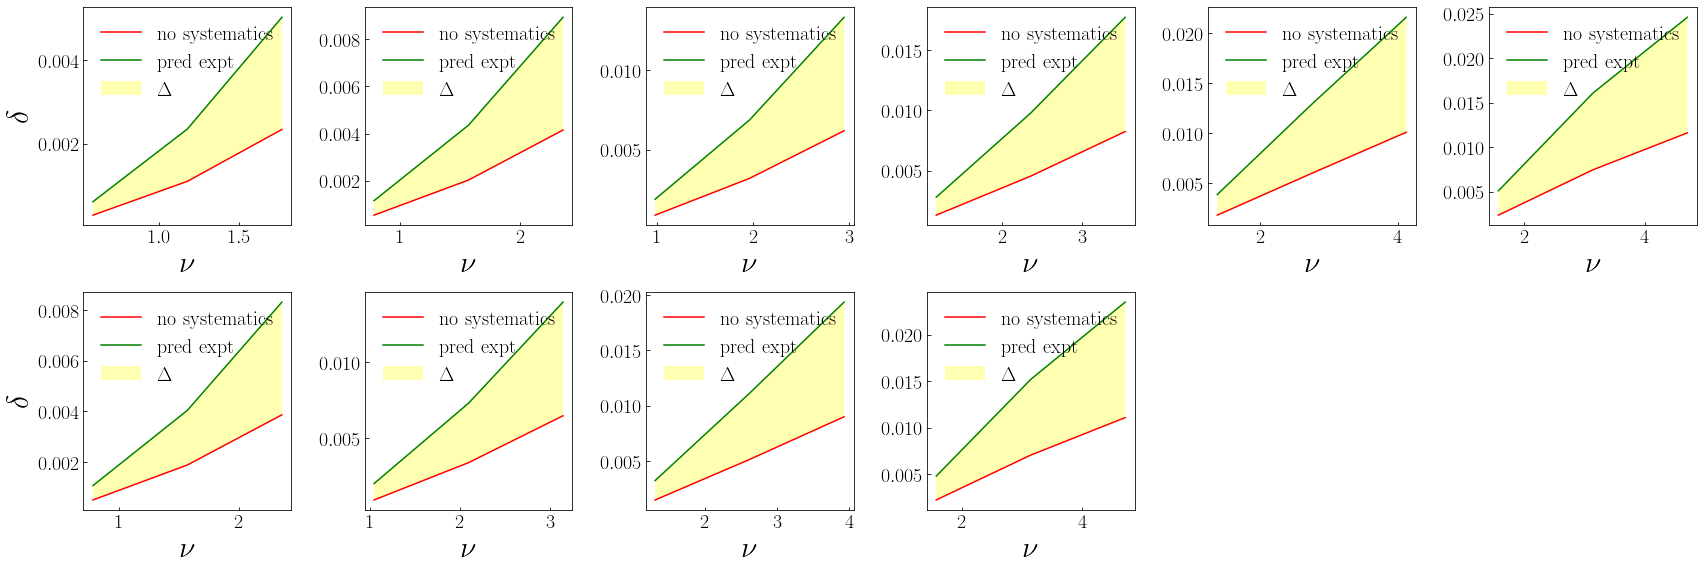

In [47]:
# w='/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/'
# data_and_theorypITD2(load('%s/data/predictions-17.dat'%w),load('%s/data/predictions-17-mod.dat'%w),w)
w2='/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/'
# uncpITD2(load('%s/data/predictions-17.dat'%w2),load('%s/data/predictions-LCS-16.dat'%w),w)
uncpITD2(load('%s/data/predictions-17.dat'%w3),load('%s/data/predictions-LCS-16.dat'%w),w3)

In [75]:
def Delta3(predictions,predictionsnosys,predictionsexp,wdir):
    zunique=np.unique(predictions['reactions']['pITD'][1001]['ZoA'])
    nrows=len(predictions['reactions']['pITD'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['pITD']:
        p=predictions['reactions']['pITD'][k]
        pns=predictionsnosys['reactions']['pITD'][k]
        pex=predictionsexp['reactions']['pITD'][k]
        #--get chi2
        c=[x for x in p if 'cov' in x]
        cov=np.zeros((len(c),len(c)))
        for i in range(len(c)):
            cov[i]=p[c[i]]
        covinv=np.linalg.inv(cov)
        vect=p['value']-np.mean(p['prediction-rep'],axis=0)
        chi2=np.einsum('i,ij,j',vect,covinv,vect)
        print(chi2)
        npts=len(vect)
        
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            theorynosys=np.mean(pns['prediction-rep'],axis=0)
            dtheorynosys=np.std(pns['prediction-rep'],axis=0)
            theoryexp=np.mean(pex['prediction-rep'],axis=0)
            dtheoryexp=np.std(pex['prediction-rep'],axis=0)
#             theorysys=np.mean(np.array(p['prediction-rep'])-np.array(pns['prediction-rep']),axis=0)
#             dtheorysys=np.std(np.array(p['prediction-rep'])-np.array(pns['prediction-rep']),axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            meanthynosys=[]
            stdthynosys=[]
            meanthyexp=[]
            stdthyexp=[]
#             meanthysys=[]
#             stdthysys=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
                    meanthynosys.append(theorynosys[j])
                    stdthynosys.append(dtheorynosys[j])
                    meanthyexp.append(theoryexp[j])
                    stdthyexp.append(dtheoryexp[j])
#                     meanthysys.append(theorysys[j])
#                     stdthysys.append(dtheorysys[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            meanthynosys=np.array(meanthynosys)
            stdthynosys=np.array(stdthynosys)
            meanthyexp=np.array(meanthyexp)
            stdthyexp=np.array(stdthyexp)
#             meanthysys=np.array(meanthysys)
#             stdthysys=np.array(stdthysys)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
#             ax.errorbar(nu,vals,yerr=alphas,fmt='.')
#             ax.axhline(y=1,color='k',alpha=0.5)
#             ax.fill_between(nu,meanthy-stdthy,meanthy+stdthy,alpha=0.3,fc='r',ec='r',label=r'$\rm full$')
#             ax.fill_between(nu,meanthynosys-stdthynosys,meanthynosys+stdthynosys,alpha=0.3,fc='g',ec='g',label=r'$\rm no~sys$')
#             ax.fill_between(nu,meanthyexp-stdthyexp,meanthyexp+stdthyexp,alpha=0.3,fc='y',ec='slategrey',label=r'$\rm pred~expt$')
            Deltafull=stdthyexp-stdthynosys
            Deltasyst=stdthy-stdthynosys
#             ax.fill_between(nu,stdthy,stdthyexp,fc='yellow',alpha=0.3,label=r'$\Delta$')
            ax.plot(nu,Deltafull/Deltafull,'k',label=r'$i={\rm exp}$')
            ax.plot(nu,Deltasyst/Deltafull,c='r',label=r'$i={\rm full}$')
#             ax.plot(nu,stdthyexp,c='g',label=r'$\rm pred~expt$')
#             ax.set_ylim(0.99,1.01)
#             ax.set_yticks([0.99,0.995,1,1.005,1.01])
            if i==0:
                ax.set_ylabel(r'$(\delta_i-\delta_{\rm no~sys})/\Delta$',size=30)
#                 ax.set_yticklabels([r'$0.99$','',r'$1$','',r'$1.01$'])
#             else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
#             if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
            if i==1: ax.legend(fontsize=20,loc='center left',frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
            ax.set_ylim(0,1.1)
            if i==0: ax.text(0.1,0.5,r'$\Delta=\delta_{\rm exp}-\delta_{\rm no~sys}$',transform=ax.transAxes,size=28)
#             if i==0: ax.text(0.1,0.3,r'$L=%i$'%p['L'][0],transform=ax.transAxes,size=30)
#             if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/Delta_pITD_syst_exp.png'%wdir)

19.69782703522685
18.628700618325013


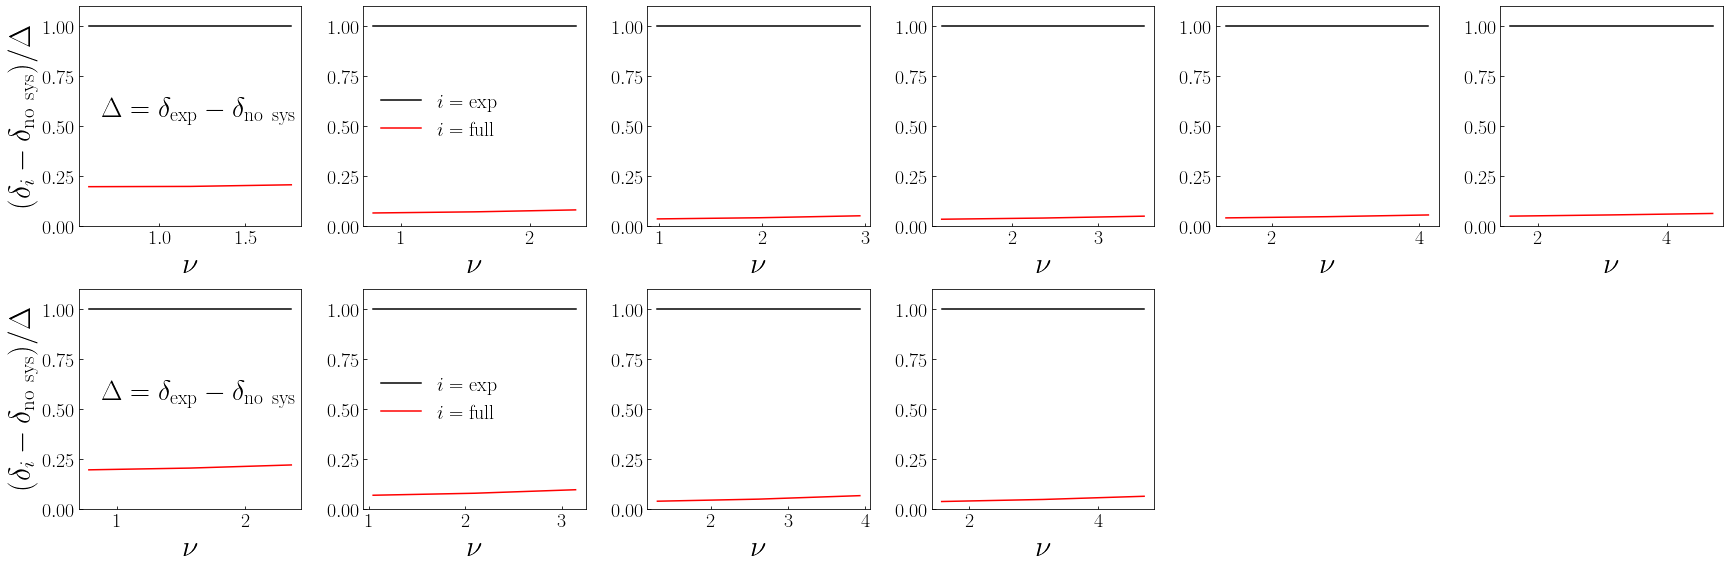

In [76]:
# w='/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/'
# data_and_theorypITD2(load('%s/data/predictions-17.dat'%w),load('%s/data/predictions-17-mod.dat'%w),w)
w2='/work/JAM/barryp/JAM/analysis-LCS/pITDnew/systematics/J1P1/'
Delta3(load('%s/data/predictions-17.dat'%w2),load('%s/data/predictions-17.dat'%w3),load('%s/data/predictions-LCS-16.dat'%w),w)

In [ ]:
def data_and_theoryccLCS(predictions,wdir):
    zunique=np.unique(predictions['reactions']['ccLCS'][12781]['ZoA'])
    nrows=len(predictions['reactions']['ccLCS'])
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    for k in predictions['reactions']['ccLCS']:
        p=predictions['reactions']['ccLCS'][k]
        #--get chi2
        thy=np.mean(p['prediction-rep'],axis=0)
        res=(p['value']-thy)/p['alpha']
        print('k=%s'%k)
        for i in range(len(res)):
            print('z=%f, nu=%f, chi2=%f'%(p['z'][i],p['nu'][i],res[i]**2))
        chi2=np.sum(res**2)
#         print(chi2)
        npts=len(res)
        
        for i in range(len(zunique)):
            cnt+=1
            theory=np.mean(p['prediction-rep'],axis=0)
            dtheory=np.std(p['prediction-rep'],axis=0)
            nu=[]
            vals=[]
            alphas=[]
            meanthy=[]
            stdthy=[]
            for j in range(len(p['N'])):
                if p['ZoA'][j]==zunique[i]:
                    nu.append(p['nu'][j])
                    vals.append(p['value'][j])
                    alphas.append(p['alpha'][j])
                    meanthy.append(theory[j])
                    stdthy.append(dtheory[j])
            nu=np.array(nu)
            vals=np.array(vals)
            alphas=np.array(alphas)
            meanthy=np.array(meanthy)
            stdthy=np.array(stdthy)
            if len(nu)==0: continue
            ax=py.subplot(nrows,ncols,cnt)
            ax.errorbar(nu,vals,yerr=alphas,fmt='.')
#             ax.axhline(y=1,color='k',alpha=0.5)
            ax.fill_between(nu,meanthy-stdthy,meanthy+stdthy,alpha=0.3,fc='r',ec='r')
#             ax.set_ylim(0.8,1.2)
#             ax.set_ylim(0.5,1.5)
#             ax.set_yticks([0.8,0.85,0.9,0.95,1,1.05,1.1,1.15,1.2])
#             ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5])
#             if i==0:
#                 ax.set_yticklabels([r'$0.8$','',r'$0.9$','',r'$1$','',r'$1.1$','',r'$1.2$'])
#                 ax.set_yticklabels(['',r'$0.6$','',r'$0.8$','',r'$1$','',r'$1.2$','',r'$1.4$',''])
#             else: ax.set_yticklabels([])
            ax.tick_params(direction='in',which='both',labelsize=20)
#             if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
#             ax.legend(fontsize=25,loc='upper left')#,frameon=False)
            ax.set_xlabel(r'$\nu$',size=30)
#             if i==0: ax.text(0.1,0.3,r'$L=%i a$'%p['L'][0],transform=ax.transAxes,size=25)
#             if i==0: ax.text(0.1,0.18,r'$m_\pi=%i~{\rm MeV}$'%p['mpi'][0],transform=ax.transAxes,size=25)
#             if i==0: ax.text(0.1,0.06,r'$a=%.3f~{\rm fm}$'%p['a'][0],transform=ax.transAxes,size=25)
#             if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/data_and_theory_ccLCS.png'%wdir)

19.09797551498275
19.994370716599576
k=12781
z=0.188000, nu=0.392699, chi2=0.441809
z=0.282000, nu=0.589049, chi2=0.739698
z=0.376000, nu=0.785398, chi2=4.108618
z=0.470000, nu=0.981748, chi2=0.022257
z=0.564000, nu=1.178097, chi2=0.177456
z=0.188000, nu=0.785398, chi2=1.056559
z=0.282000, nu=1.178097, chi2=0.104258
z=0.376000, nu=1.570796, chi2=0.017297
z=0.470000, nu=1.963495, chi2=0.034441
z=0.564000, nu=2.356194, chi2=0.425189
z=0.188000, nu=1.178097, chi2=0.176972
z=0.282000, nu=1.767146, chi2=0.679245
z=0.376000, nu=2.356194, chi2=0.013620
z=0.470000, nu=2.945243, chi2=0.035653
z=0.564000, nu=3.534292, chi2=0.151995
z=0.188000, nu=1.570796, chi2=0.176818
z=0.282000, nu=2.356194, chi2=0.002801
z=0.376000, nu=3.141593, chi2=0.004996
z=0.470000, nu=3.926991, chi2=0.008229
z=0.564000, nu=4.712389, chi2=0.127802
k=13581
z=0.188000, nu=0.392699, chi2=1.394779
z=0.282000, nu=0.589049, chi2=7.384025
z=0.376000, nu=0.785398, chi2=1.327380
z=0.470000, nu=0.981748, chi2=0.350414
z=0.564000,

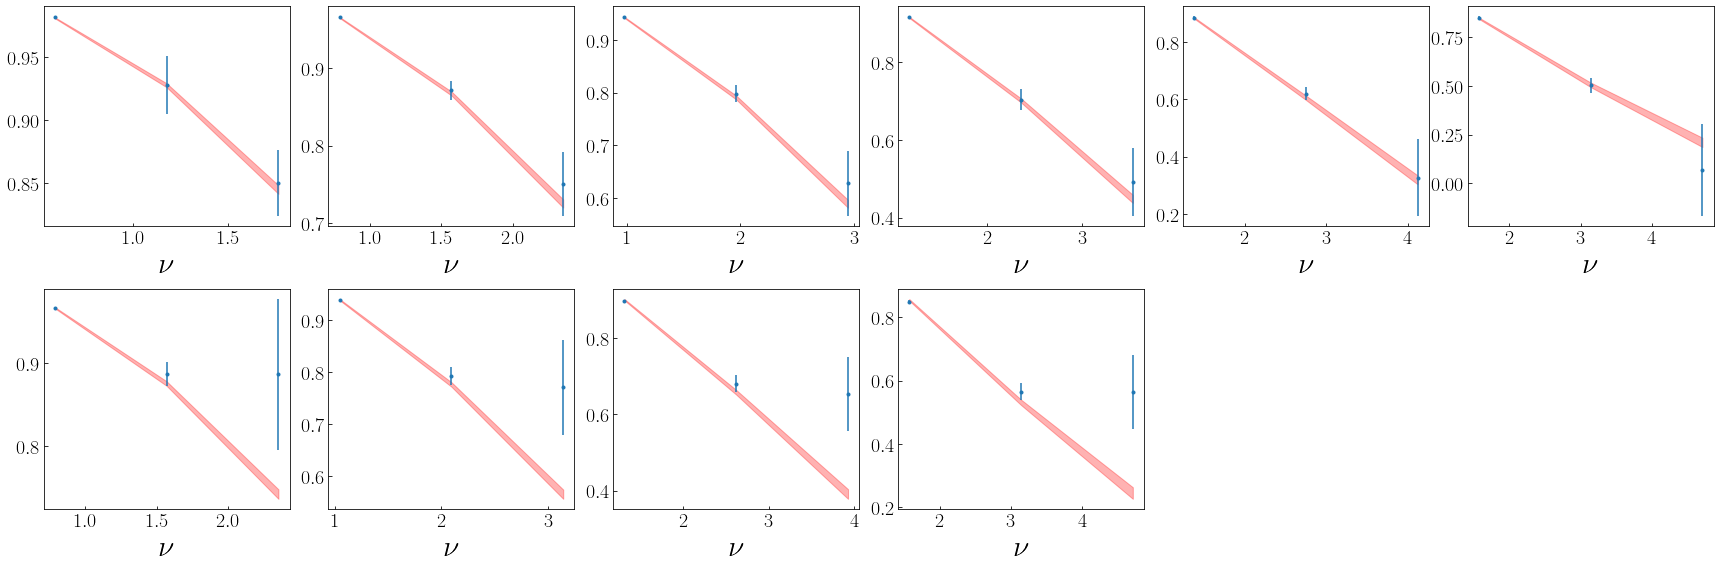

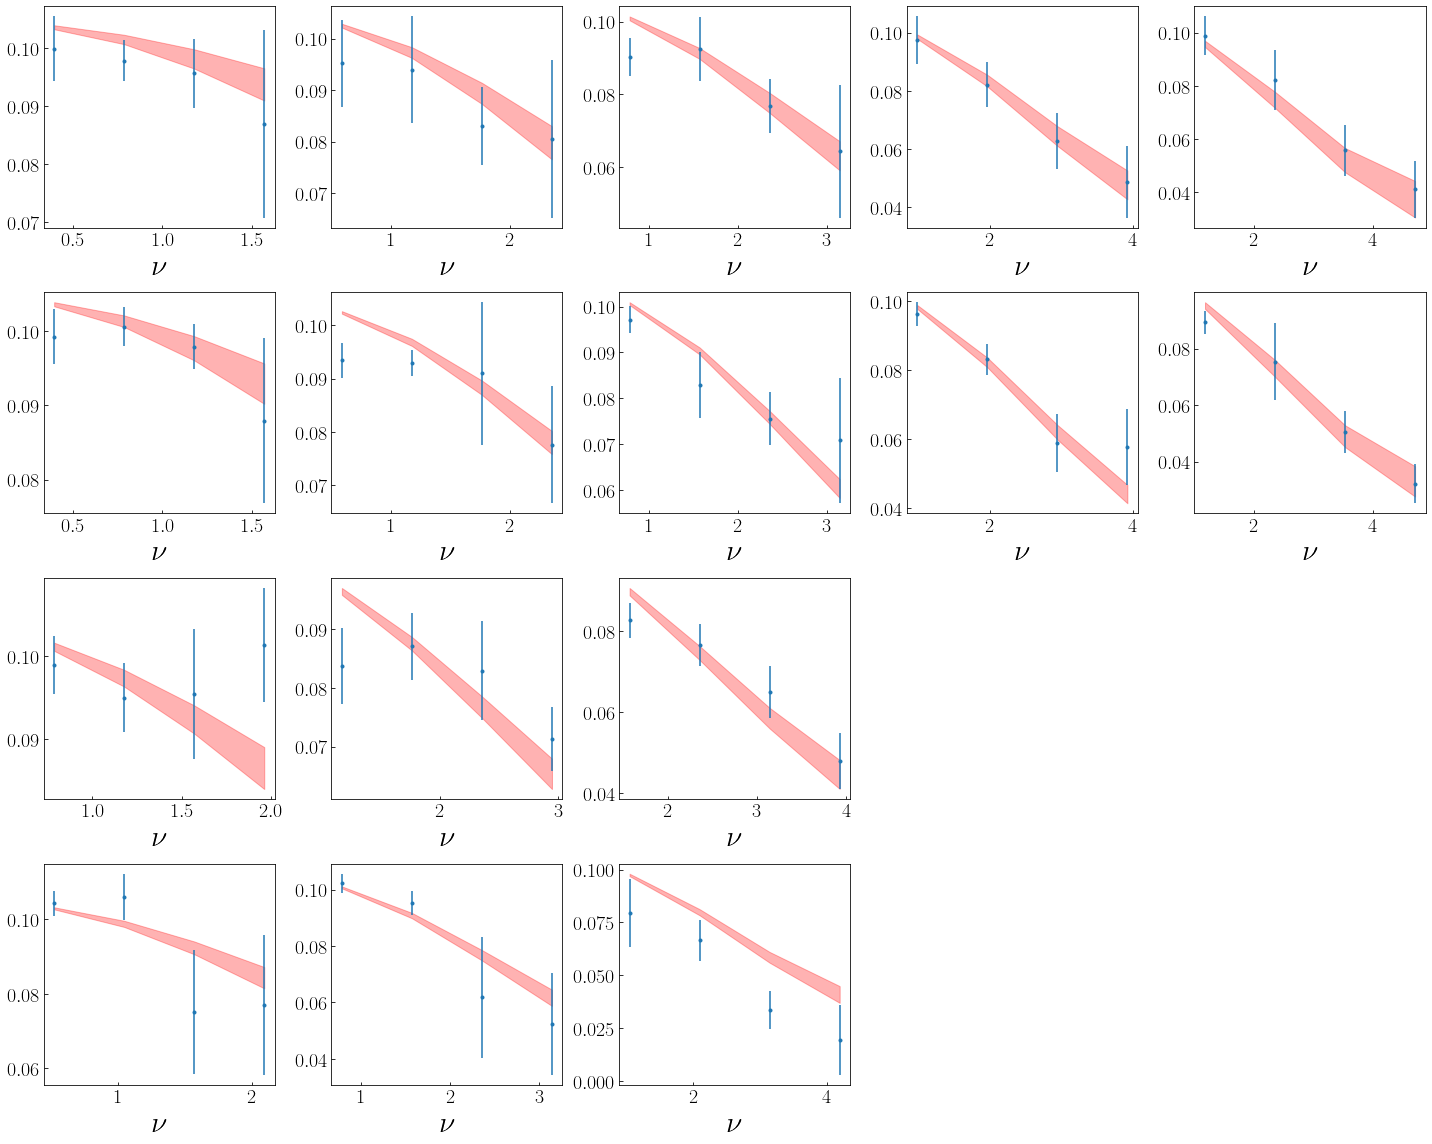

In [111]:
# wdirs2=['/work/JAM/barryp/JAM/analysis-LCS/combinednew/NLOmu2/']
for w in wdirs:
#     if w!=wdirs[0]: continue
    p=load('%s/data/predictions-17.dat'%w)
#     p=load('%s/data/predictions-18.dat'%w)
#     flag=False
#     for k in os.listdir('%s/gallery'%w):
#         if 'data_over_theory' in k: flag=True
#     if flag: continue
    if 'pITD' in w: data_and_theorypITD(p,w)
    elif 'ccLCS' in w: data_and_theoryccLCS(p,w)
#     data_and_theoryccLCS(p,w)